# Reddit, Set, Go: Deciphering What Redditors Are Really Looking For
## *What are Filipino Redditors really looking for in dating in r/phr4r*

**Big Data and Cloud Computing Final Project**

**MSDS 2020 Learning Team 4**
 * Ria Ysabelle L. Flora
 * Crisanto E. Chua
 * Armand Louis A. De Leon
 * Jeddahlyn V. Gacera
 
**Asian Institute of Management**

# I. Executive Summary

Given the privilege of `anonymity`, `Reddit` has always been a platform that enabled its users to `explicitly post` about what they want, with special subreddits being created for several niche topics. Subreddits catering to these are often tagged as `r4r` or `redditor-for-redditor` and with that, the aim of this study is to extract all the information on the posts from the `Philippine-based subreddit r/phr4r` to paint a clearer picture of the `dating` and `hook-up culture` in the Philippines. Collection of the data was done through an updated source in Jojie. `Frequent Itemset Mining (FIM)` and `Association Rule Mining (ARM)` was employed to extract the most frequently occurring verbs, adjectives, and nouns from individual posts. Data points were identified according to `gender`, `age`, and `sexual orientation` due to the consistent topic name formatting imposed in the subreddit. The demographic information combined with the FIM and ARM output was used for the profiling of different age groups or sexual orientation to create a more granular analysis.

# II. Introduction

`Reddit` is an online messaging board established at the University of Virginia in 2005 and is currently, according to its website, the `5th most visited site` in the United States of America (USA). Users at this site are distinguished by their unique user identifications (user ID) whereas the content posted in the website are user-generated and vary in types: text, video, and links. These contents are further organized according to user-generated communities called `subreddits`, or subs as popularly called, which cater to different arrays of interests – encompassing a wide range of niche and general topics. Each subreddit has its own theme, culture, and rules (as set by its moderators). 

One of the popular subreddits would be `r/r4r` which stands for `redditor – for – redditor` wherein community users, post personal to meet other users. Posts in this subreddit cover dating, marriage proposals, academic support, video games, poetry, playing board games, and many more. Since its cake day in April 2010, it currently has a registry of 284,000 users. International versions of which have also emerged, such as `r/phr4r in the Philippines`, `r/euro4euro for Europe`, `r/r4rtoronto for Toronto Canada`, and many more; all of which, are anchored on the same objective of connecting Reddit users to each other for whichever purpose indicated. Nonetheless, a distinct feature across these subreddits would be the formatting at which its posts are written accordingly: &lt;age&gt; [&lt;r4r&gt;] &lt;title&gt; wherein users fill in the tags in between the angled brackets with r being indicative of the user’s gender and gender preference.  

Aside from the distinct text formatting in these subreddits, r4r subreddits are distinct for the `cloak of anonymity` it provides to its users which is disparate from other dating and social media platforms.  It is also worth noting that all posts in these subreddits are purely textual and do not include images – and thus establishes complete anonymity for each post. Given this, and in line with a study by (Curlew, 2019), forms social media platforms that subscribe to real name basis lead to identity curation whereas platforms that enable its users to be anonymous through usernames and/or complete anonymity lead to less inhibitions and more elaborate forms of self-expression. Hence, through Reddit’s r4r subreddits, users are provided with an `avenue to express themselves without inhibitions brought by social factors` such as family dynamics, public reputation, and body image.    

Given the growing number of Reddit users and the blanket of anonymity it provides, the objective of the study is to find out `what Filipino Redditors are looking for in dating in the Subreddit r/phr4r`. Accomplishing this would entail extracting information on the posts through `data mining techniques and natural language processing` – all towards painting a clearer picture of the `dating and hook-up culture in the Philippines`. This study is particularly anchored on the nature of the subreddit r/phr4r wherein majority of the posts are particularly on dating and hook ups with hook ups being defined as a casual encounter ranging from kissing to intercourse with no defined expectations on progressing the relationship towards a fully committed one (Black, S., et al., 2019).  

The study shall be delimited to the r/phr4r subreddit and shall not encompass any other similar subreddits of the same nature. Moreover, the study only took into accounts posted from January 2016 to August 2019.

# III. Methodology

The following steps were taken for this study:

**1. Data Description and Collection**<br>
* Data gathering<br>
* Text data<br>

**2. Data Cleaning and Preprocessing**<br>
* POS tagging<br>
* N-grams<br>

**3. Exploratory Data Analysis**<br>

**4. Profiling**

**5. Data Mining**<br>

* Frequent Itemset Mining<br>
* Association Rule Mining

## 1.	Data Description and Collection

Data on this study is from one of the most popular social platforms, `Reddit`, wherein users can explicitly post about what they want, with special subreddits being created for several niche topics. Specifically, we will be analyzing the Philippine-based subreddit `r/phr4r` under the main subreddit r/r4r.

Due to its popularity and robustness, it is one of the websites being collected for big data analysis. <a href="https://files.pushshift.io/">Pushshift.io</a> is a site maintained by Jason Baumgartner and contains various articles relating to big data, social media ingest and analysis and general technology trends. This includes Reddit data (redditors, subreddits, submittions, comments, etc.) which can be found <a href="https://files.pushshift.io/reddit/submissions/">here</a>.

### a. Data gathering

All reddit submissions data found in Pushshift.io were copied to jojie (`/mnt/data/public/reddit/submissions/RS_<YYYY>_<MM>.*`). These `46 files` were then copied to an `s3 bucket`, and then to an `efs` mounted to all `AWS instances` (master and slaves) for processing.

In [1]:
from dask.distributed import Client
client = Client('54.249.93.186:8786')
client

<Client: 'tcp://172.31.39.227:8786' processes=12 threads=24, memory=98.68 GB>

In [39]:
import dask
import dask.dataframe as dd
import dask.bag as db
import pandas as pd
import pickle
import glob
import json
import re

#### Selected features

In [3]:
features = ['subreddit', 'created_utc', 'author', 'title', 
            'selftext', 'ups', 'downs', 'score', 'num_comments']

In [6]:
def get_features(r):
    '''Returns a dictionary with features as keys and values from the data 
       found in file for that key'''
    j = json.loads(r)
    return json.dumps([j[f] if f in j else None for f in features])

#### Select phr4r subreddit

In [5]:
sub = re.compile(r'"subreddit":"phr4r"')

def re_filter(r):
    '''Returns True if the file containg phr4r, else False'''
    if sub.search(r):
        return True
    return False

#### Process bz2 files (January 2016 - October 2017) and save to a pickle file

In [7]:
bz_raw = db.read_text('/home/ubuntu/efs/submissions/RS*.bz2')

In [8]:
bz_sub = bz_raw.filter(re_filter).map(get_features)

In [9]:
bz_sub.to_textfiles(path='/home/ubuntu/efs/bz_files/')

['/home/ubuntu/efs/bz_files/00.part',
 '/home/ubuntu/efs/bz_files/01.part',
 '/home/ubuntu/efs/bz_files/02.part',
 '/home/ubuntu/efs/bz_files/03.part',
 '/home/ubuntu/efs/bz_files/04.part',
 '/home/ubuntu/efs/bz_files/05.part',
 '/home/ubuntu/efs/bz_files/06.part',
 '/home/ubuntu/efs/bz_files/07.part',
 '/home/ubuntu/efs/bz_files/08.part',
 '/home/ubuntu/efs/bz_files/09.part',
 '/home/ubuntu/efs/bz_files/10.part',
 '/home/ubuntu/efs/bz_files/11.part',
 '/home/ubuntu/efs/bz_files/12.part',
 '/home/ubuntu/efs/bz_files/13.part',
 '/home/ubuntu/efs/bz_files/14.part',
 '/home/ubuntu/efs/bz_files/15.part',
 '/home/ubuntu/efs/bz_files/16.part',
 '/home/ubuntu/efs/bz_files/17.part',
 '/home/ubuntu/efs/bz_files/18.part',
 '/home/ubuntu/efs/bz_files/19.part',
 '/home/ubuntu/efs/bz_files/20.part',
 '/home/ubuntu/efs/bz_files/21.part']

In [10]:
df_bz = dd.read_json('/home/ubuntu/efs/bz_files/*', lines=True).compute()

In [12]:
df_bz.shape

(5494, 9)

In [24]:
df_bz.columns = features

In [29]:
df_bz['texts'] = df_bz['title']+'\n'+df_bz['selftext']

In [30]:
df_bz.head()

subreddit  created_utc       author  \
0     phr4r   1451891616        EdWao   
1     phr4r   1451950820    [deleted]   
2     phr4r   1452053372    [deleted]   
3     phr4r   1452065137  ThreesomePH   
4     phr4r   1452248658    [deleted]   

                                               title  \
0                              [m4m] looking for FUN   
1     [M4F] Let's have a drink? [HOHOL/NSA/Anything]   
2                     30 [M4F] Shaw, Movie and chill   
3  23 [M4F] Manila area. Actually looking for a t...   
4                30 [M4F] San Pablo Laguna, hangout?   

                                            selftext  ups  downs  score  \
0  Hey. I'm 18 bi m from Sta. Mesa Manila. Lookin...  2.0    0.0      2   
1                                          [removed]  1.0    0.0      1   
2                                          [deleted]  2.0    0.0      2   
3  So my girlfriend and I want to try something n...  7.0    0.0      7   
4                                          [deleted]  1.0    0.0      1   

   num_comments                                              texts  
0             8  [m4m] looking for FUN\nHey. I'm 18 bi m from S...  
1             0  [M4F] Let's have a drink? [HOHOL/NSA/Anything]...  
2             0          30 [M4F] Shaw, Movie and chill\n[deleted]  
3             8  23 [M4F] Manila area. Actually looking for a t...  
4             0     30 [M4F] San Pablo Laguna, hangout?\n[deleted]

In [41]:
with open('/home/ubuntu/efs/files/df_bz.pkl', 'wb') as f:
    pickle.dump(df_bz, f)

#### Process xz files (November 2017- October 2018) and save to a pickle file

In [13]:
xz_raw = db.read_text('/home/ubuntu/efs/submissions/RS*.xz')

In [14]:
xz_sub = xz_raw.filter(re_filter).map(get_features)

In [15]:
xz_sub.to_textfiles(path='/home/ubuntu/efs/xz_files/')

['/home/ubuntu/efs/xz_files/00.part',
 '/home/ubuntu/efs/xz_files/01.part',
 '/home/ubuntu/efs/xz_files/02.part',
 '/home/ubuntu/efs/xz_files/03.part',
 '/home/ubuntu/efs/xz_files/04.part',
 '/home/ubuntu/efs/xz_files/05.part',
 '/home/ubuntu/efs/xz_files/06.part',
 '/home/ubuntu/efs/xz_files/07.part',
 '/home/ubuntu/efs/xz_files/08.part',
 '/home/ubuntu/efs/xz_files/09.part',
 '/home/ubuntu/efs/xz_files/10.part',
 '/home/ubuntu/efs/xz_files/11.part']

In [16]:
df_xz = dd.read_json('/home/ubuntu/efs/xz_files/*', lines=True).compute()

In [17]:
df_xz.shape

(13711, 9)

In [25]:
df_xz.columns = features

In [31]:
df_xz['texts'] = df_xz['title']+'\n'+df_xz['selftext']

In [32]:
df_xz.head()

subreddit  created_utc         author  \
0     phr4r   1509505274   watchmeplay_   
1     phr4r   1509507757  123Hihellobye   
2     phr4r   1509509229      [deleted]   
3     phr4r   1509511793      [deleted]   
4     phr4r   1509512861      [deleted]   

                                              title  \
0                              25[M4F] Wanna watch?   
1  25 [F4M] looking for a friend with a big heart 😉   
2          32 [M4F] Manila looking for conversation   
3                                  25 [M4F] NSA/FWB   
4                                   F4R Pasig Area.   

                                            selftext  ups  downs  score  \
0                                          [removed]  NaN    NaN      1   
1  Just kidding 😀\n\nLooking for a good friend wh...  NaN    NaN     10   
2                                          [deleted]  NaN    NaN      2   
3                                          [deleted]  NaN    NaN      1   
4                                          [removed]  NaN    NaN      1   

   num_comments                                              texts  
0             0                    25[M4F] Wanna watch?\n[removed]  
1            12  25 [F4M] looking for a friend with a big heart...  
2             3  32 [M4F] Manila looking for conversation\n[del...  
3             0                        25 [M4F] NSA/FWB\n[deleted]  
4             0                         F4R Pasig Area.\n[removed]

In [42]:
with open('/home/ubuntu/efs/files/df_xz.pkl', 'wb') as f:
    pickle.dump(df_xz, f)

#### Process zst files (November 2018- August 2019) and save to a pickle file

In [18]:
zst_raw = db.read_text('/home/ubuntu/efs/submissions/RS*.zst')

In [19]:
zst_sub = zst_raw.filter(re_filter).map(get_features)

In [20]:
zst_sub.to_textfiles(path='/home/ubuntu/efs/zst_files/')

['/home/ubuntu/efs/zst_files/0.part',
 '/home/ubuntu/efs/zst_files/1.part',
 '/home/ubuntu/efs/zst_files/2.part',
 '/home/ubuntu/efs/zst_files/3.part',
 '/home/ubuntu/efs/zst_files/4.part',
 '/home/ubuntu/efs/zst_files/5.part',
 '/home/ubuntu/efs/zst_files/6.part',
 '/home/ubuntu/efs/zst_files/7.part',
 '/home/ubuntu/efs/zst_files/8.part',
 '/home/ubuntu/efs/zst_files/9.part']

In [21]:
df_zst = dd.read_json('/home/ubuntu/efs/zst_files/*', lines=True).compute()

In [22]:
df_zst.shape

(42474, 9)

In [26]:
df_zst.columns = features

In [33]:
df_zst['texts'] = df_zst['title']+'\n'+df_zst['selftext']

In [34]:
df_zst.head()

subreddit  created_utc            author  \
0     phr4r   1541030869        Jsadf313d1   
1     phr4r   1541030922        craigchina   
2     phr4r   1541031135         Pattaptap   
3     phr4r   1541031626  MoreAboutChances   
4     phr4r   1541035382      Pluckedwings   

                                               title  \
0  23[M4F] South. Let’s get rid of stress over th...   
1                 29/24 MF4F - travel guide and more   
2             MF4M looking for a thirdy cavite area.   
3  22 [M4F] UPD - Sexual frustrations in college ...   
4  [28F4A] Anyone game to hangout this long weeke...   

                                            selftext  ups  downs  score  \
0                                          [removed]  NaN    NaN      1   
1                                          [removed]  NaN    NaN      1   
2                                          [removed]  NaN    NaN      1   
3  Hello there. Sa totoo lang sobrang stress ko t...  NaN    NaN      1   
4                                          [removed]  NaN    NaN      1   

   num_comments                                              texts  
0             0  23[M4F] South. Let’s get rid of stress over th...  
1             0      29/24 MF4F - travel guide and more\n[removed]  
2             0  MF4M looking for a thirdy cavite area.\n[removed]  
3             0  22 [M4F] UPD - Sexual frustrations in college ...  
4             0  [28F4A] Anyone game to hangout this long weeke...

In [43]:
with open('/home/ubuntu/efs/files/df_zst.pkl', 'wb') as f:
    pickle.dump(df_zst, f)

#### Combine all and prepare for data cleaning using NLP

In [51]:
df_all = df_bz.append(df_xz).append(df_zst)[['texts']]
df_all.head()

texts
0  [m4m] looking for FUN\nHey. I'm 18 bi m from S...
1  [M4F] Let's have a drink? [HOHOL/NSA/Anything]...
2          30 [M4F] Shaw, Movie and chill\n[deleted]
3  23 [M4F] Manila area. Actually looking for a t...
4     30 [M4F] San Pablo Laguna, hangout?\n[deleted]

#### Save to a pickle file

In [53]:
with open('/home/ubuntu/efs/files/df_all.pkl', 'wb') as f:
    pickle.dump(df_all, f)

### b. Text data

It is possible to mine the age and sexual preference of phr4r users due to the standard format that each post must follow in accordance with the subreddit’s rules. Each post must have the following format:  

#### <center>&lt;AGE&gt; [(M/F)4(M/F/A)] &lt;Post title/header&gt;</center>
 

For example, a straight, 24-year-old male will indicate this as “24 [M4F]”, while a homosexual 22-year-old female will use “22 [F4F]”. The “A” is used to indicate that the poster is indifferent to the sex of the person they are looking for. Posts by couples may also be formatted as [MF4A] or [FF4M], indicating a couple is interested in a third party. These posts are filtered out from scraping to keep analysis simple. 

 

The bodies of these posts vary in content, although a common format used in most posts is as follow: 

<pre> 
An introduction to provide context

“About me”, which enumerates enough traits and attributes to describe but not give away identity 

“About you”, enumerates the user’s requirements or preferences for the person they would like to meet 

</pre>

Due to most posts having descriptions of themselves and preferred other, it would make sense to filter the text according to only nouns, verbs, adjectives, and adverbs. The process of tagging and filtering according to part of speech is detailed later in this paper. 

## 2. Data Cleaning and Preprocessing
Text pre-processing is the first step in preparing text data for analysis. For this study, the following were done to clean the text before part of speech (POS) tagging: 

1. Lowercase all characters 

2. Remove all special characters and punctuations 

3. Lemmatizing and POS tagging (done simultaneously) 

4. Stop word removal 

As an additional note, stop words are removed after POS tagging since the model involved in POS tagging may lose information it needs to properly tag words.

### a. POS tagging 

POS tagging allows a machine to properly identify how a certain word was used within a sentence, whether it was used as a noun, adjective, verb, etc. This has multiple applications, such as in telling a machine how to pronounce a word in text-to-speech (TTS) programs (Bellegarda, 2015), in aspect-level sentiment analysis, or automated grammar checking. POS tagging makes it possible to filter out particular parts of speech that may not be relevant to the analysis, and in a way can be used as a crude means of dimensionality reduction. 

For this study, the POS tagger in the SpaCy library was used. Hence, lemmatizing is done alongside the POS tagging process. Parts of speech such as nouns, verbs, adjectives, and adverbs were retained for analysis.

### b. N-grams 

N-grams were not used since it may conflict with the point of the study, which is to find which words are most likely to occur together. It may be redundant to consider two-word sequences since the concern of the study is to find relationships between single words in the posts. 

Sexual Orientation 

As mentioned earlier, the format <AGE> [(M/F)4(M/F/A)] <Post title/header> allows us to infer the sexual orientation of phr4r users. For simplicity, posts seeking the opposite sex are tagged straight and posts seeking the same sex are tagged LGBT. Posts such as [M4A] or [F4A] are tagged as indeterminate and filtered out of the analysis.

In [211]:
import pickle
import pandas as pd
import numpy as np
import re
import spacy
import nltk
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('tagsets')
nltk.download('brown')
nltk.download('universal_tagset')
import string 
import gensim
from gensim import corpora

nlp = spacy.load('en_core_web_sm')
stops2 = spacy.lang.en.stop_words.STOP_WORDS

word_lem = WordNetLemmatizer()

#### Load combined dataframe

In [212]:
with open('df_all.pkl', 'rb') as f:
    df_all = pickle.load(f)

In [66]:
df_all.reset_index(drop=True, inplace=True)

In [67]:
df_all.head()

texts
0  [m4m] looking for FUN\nHey. I'm 18 bi m from S...
1  [M4F] Let's have a drink? [HOHOL/NSA/Anything]...
2          30 [M4F] Shaw, Movie and chill\n[deleted]
3  23 [M4F] Manila area. Actually looking for a t...
4     30 [M4F] San Pablo Laguna, hangout?\n[deleted]

In [68]:
df_all.loc[10, 'texts']

"22 [M4F], Vito Cruz-DLSU area. In a relationship, trying to find someone on the same bench.\nSomething something casual and fun. Haha. Sorry for the boring description. Just PM and we'll get started.\n\nCheers!"

#### Text Super Pre-Processor

In [213]:
stops = stopwords.words('english') + [
            '-PRON-', 'someone', 'somebody', 'lf', 'look', 'go', 'get', 'let', 
           'want', 'know', 'sa', 'ang', 'ng', 'nang', 'mo', 'ni', 'ka', 'kay', 
           'at', 'ko', 'kasi', 'pero', 'wanna', 'para', 'lang', 'ig', 'na', 
           'ako', 'naman', 'tapos', 'di', 'din', 'rin', 'ang', 'kung', 'siya', 
           'ig', 'im', 'na', 'mga', 'uhmm', 'uhm', 'to', 'hahaha', 'yung', 
           'haha', 'basta', 'f', 'baka', 'walang', 'akong', 'kasama', 'tara', 
           'dito', 'ba', 'pwede', 'lol', 'ano', 'po', 'sana', 'pag', 'g', 
           'tayo', 'talaga', 'female', 'guy', 'hindi', 'kaya', 'pa', 'medyo', 
           'usap', 'ps', 'inom', 'mag', 'man', 'kahit', 'gusto', 'wala', 
           'amp', 'give', 'may', 'mf', 'p']

In [69]:
def clean_text(text, parts_of_speech=['ADJ' ,'NOUN', 'ADV', 'VERB', 'PROPN'],
              remove_sw=True, sw=stops):
    """
    Cleans text and filters according to part of speech.
    
    Parameters
    ----------
    text : str
    
    parts_of_speech : list of strings
        refer to parts of speech in SpaCy
        
    remove_sw : bool
    
    sw : list of strings
        add your own if necessary
        
    Returns
    -------
    out3 : str
        string with parts of speech filtered
    """
    # cleaning
    text = text.lower()
    text = text.replace('[removed]', '')
    text = text.replace('[deleted]', '')
    text = text.replace('\xa0', ' ')
    text = text.replace('\n', ' ')
    text = text.replace('\r', ' ')
    text = re.sub(r'[^\w\s]+', ' ', text)
    text = re.sub("p*\d", "", text)
    text = re.sub(r" +", ' ', text)
    
    # pass text into nlp then remove stopwords
    text = nlp(text)
    
    # .lemma_ and .pos_ are helpful extracting the lemmatized
    # word and part of speech.
    
    out = []
    for token in text:
         out.append((token.lemma_, token.pos_))
    poss = parts_of_speech
    
    out3 = ''
    for item in out:
        if item[1] in poss:
            out3 = out3 + ' ' + item[0]
    
    if remove_sw:
        dummy = out3.split()
        dummy = [word for word in dummy if word not in sw]
        out3 = ' '.join(dummy)
        return set(out3.strip().split())
    
    else:
        return set(out3.strip().split())

In [70]:
def tabulate(corpus, parts_of_speech=['ADJ' ,'NOUN', 'ADV', 'VERB', 'PROPN'],
              remove_sw=True, sw=stops):
    """
    Converts phr4r raw text into a table.
    
    Parameters
    ----------
    Corpus : list of strings
    
    Returns
    -------
    df : pandas DataFrame
    """
    age = []
    sex = []
    so = []
    document = []

    for doc in corpus:
        try:
            age_ = re.findall(r"^(\d{2})", doc)[0]
            doc = doc.replace(age_, '')
        except:
            age_ = '0'
            
        try:
            stat = re.findall(r"(\[?[MmFf]4[MmFfAa]\]?)", doc)[0]
            doc = doc.replace(stat, '')
            stat = re.findall(r"\[?([MmFf])4([MmFfAa])\]?", stat)[0]
            stat = (stat[0].upper(), stat[1].upper())
        except:
            stat = ('Unknown', 'Unknown')
        
        age.append(int(age_))
        sex.append(stat[0])

        if stat[0]=='Unknown' or stat[1]=='Unknown':
            so.append("Unknown")
        elif stat[0].lower()==stat[1].lower():
            so.append("Homosexual")
        elif stat[1].lower()=="a":
            so.append("Indeterminate")
        else:
            so.append("Straight")
        
        word_set = clean_text(doc, parts_of_speech=parts_of_speech)
        document.append(word_set)
    
    df = pd.DataFrame({"Age": age, "Sex": sex, "Sexual Orientation": so, 
                       "Word Set": document})
    return df

#### Combine all reddit texts into a list of texts

In [71]:
all_txt = df_all['texts'].values

In [72]:
len(all_txt)

61679

#### Preprocess data and extract only `verbs`, `adjectives` and `nouns` (including `proper nouns`)

In [76]:
df = tabulate(all_txt, parts_of_speech=['ADJ' ,'NOUN', 'VERB', 'PROPN'])

In [77]:
df.head(100)

Age Sex Sexual Orientation  \
0     0   M         Homosexual   
1     0   M           Straight   
2    30   M           Straight   
3    23   M           Straight   
4    30   M           Straight   
..  ...  ..                ...   
95   27   M           Straight   
96   24   M           Straight   
97    0   M           Straight   
98    0   F      Indeterminate   
99   23   M           Straight   

                                             Word Set  
0       {bi, old, place, fun, manila, sta, mesa, age}  
1                                 {drink, hohol, nsa}  
2                                {movie, chill, shaw}  
3   {buddy, new, time, take, try, manila, come, re...  
4                       {san, hangout, pablo, laguna}  
..                                                ...  
95                               {hohol, like, cocol}  
96  {cunnilingu, lean, manila, work, lay, girl, se...  
97                           {need, area, fill, taft}  
98  {bvs, manila, inbox, watch, theater, optional,...  
99  {massage, good, herb, sex, stupid, hour, bonus...  

[100 rows x 4 columns]

In [78]:
df.shape

(61679, 4)

#### Investigate quality of data

In [80]:
df['Sex'].unique()

array(['M', 'F', 'Unknown'], dtype=object)

In [143]:
df['Sexual Orientation'].unique()

array(['Homosexual', 'Straight', 'Indeterminate', 'Unknown'], dtype=object)

**`Sex` and `Sexual Orientation` have the correct values.**

In [144]:
sorted(df['Age'].unique().tolist())[:10]

# false alarms: 1, 10, 12 -> change to 0

# real: 11 -> no change

[0, 1, 10, 11, 12, 15, 16, 17, 18, 19]

**Ages `1, 10, 12` are not real ages (upon checking the original data), hence will be changed to 0. Unfortunately, `11` was stated as a real age.**

In [ ]:
df.loc[df.Age==1, 'Age'] = 0
df.loc[df.Age==10, 'Age'] = 0
df.loc[df.Age==12, 'Age'] = 0

In [182]:
sorted(df['Age'].unique().tolist())[30:]

[43, 44, 45, 46, 47, 48, 50, 51, 52, 59, 60, 62, 66, 69, 70, 88, 99]

**Age `66` was written as 666 by author, hence will be changed to 0**

In [193]:
df.loc[[21554, 34276], 'Age'] = 0

#### Load processed data to pickle

```python
with open('df_adj_n_v_propn.pkl', 'wb') as f:
    pickle.dump(df, f)
```

#### Read original dataframes which include more columns

In [202]:
with open('df_bz.pkl', 'rb') as f:
    df_bz = pickle.load(f)
    
with open('df_xz.pkl', 'rb') as f:
    df_xz = pickle.load(f)
    
with open('df_zst.pkl', 'rb') as f:
    df_zst = pickle.load(f)
    
df_all_cols = df_bz.append(df_xz).append(df_zst).reset_index(drop=True)

#### Convert unix timestamp to datetime

In [203]:
df_all_cols['date'] = pd.to_datetime(df_all_cols['created_utc'], unit='s')

#### Join previous `df` with `df_all_cols`

In [204]:
df_all_cols = df.join(df_all_cols)

In [205]:
df_all_cols.head(2)

Age Sex Sexual Orientation                                       Word Set  \
0    0   M         Homosexual  {bi, old, place, fun, manila, sta, mesa, age}   
1    0   M           Straight                            {drink, hohol, nsa}   

  subreddit  created_utc     author  \
0     phr4r   1451891616      EdWao   
1     phr4r   1451950820  [deleted]   

                                            title  \
0                           [m4m] looking for FUN   
1  [M4F] Let's have a drink? [HOHOL/NSA/Anything]   

                                            selftext  ups  downs  score  \
0  Hey. I'm 18 bi m from Sta. Mesa Manila. Lookin...  2.0    0.0      2   
1                                          [removed]  1.0    0.0      1   

   num_comments                                              texts  \
0             8  [m4m] looking for FUN\nHey. I'm 18 bi m from S...   
1             0  [M4F] Let's have a drink? [HOHOL/NSA/Anything]...   

                 date  
0 2016-01-04 07:13:36  
1 2016-01-04 23:40:20

#### Load dataframe with complete columns to pickle

```python
with open('df_all_cols.pkl', 'wb') as f:
    pickle.dump(df_all_cols, f)
```

## 3. Exploratory Data Analysis

Now that we have cleaned the data, we'll perform Exploratory Data Analysis to extract initial insights on the phr4r subreddit submissions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import collections

In [2]:
with open('df_adj_n_v_propn.pkl', 'rb') as pkl1:
    df1  = pickle.load(pkl1)
    
df1.head()

Age Sex Sexual Orientation  \
0    0   M         Homosexual   
1    0   M           Straight   
2   30   M           Straight   
3   23   M           Straight   
4   30   M           Straight   

                                            Word Set  
0      {bi, age, sta, mesa, place, fun, manila, old}  
1                                {hohol, drink, nsa}  
2                               {shaw, movie, chill}  
3  {come, new, reply, time, girlfriend, inbox, ta...  
4                      {hangout, laguna, pablo, san}

In [81]:
df1.shape

(61679, 4)

#### Analysis on posts per sexual orientation

In [3]:
so  = list(df1['Sexual Orientation'].unique())

In [4]:
df1['Sexual Orientation'].value_counts(normalize=True)*100

Straight         69.809822
Indeterminate    17.592698
Homosexual        6.358728
Unknown           6.238752
Name: Sexual Orientation, dtype: float64

In [5]:
perc_so = df1['Sexual Orientation'].value_counts(normalize=True)*100

so = {}
so['Straight'] = perc_so[0]
so['Indeterminate'] = perc_so[1]
so['Homosexual'] = perc_so[2]
so['Unknown'] = perc_so[3]

In [6]:
labels_so = []
vals_so = []
for i,j in so.items():
    labels_so.append(f'{i} {j: .4}%')
    vals_so.append(j)

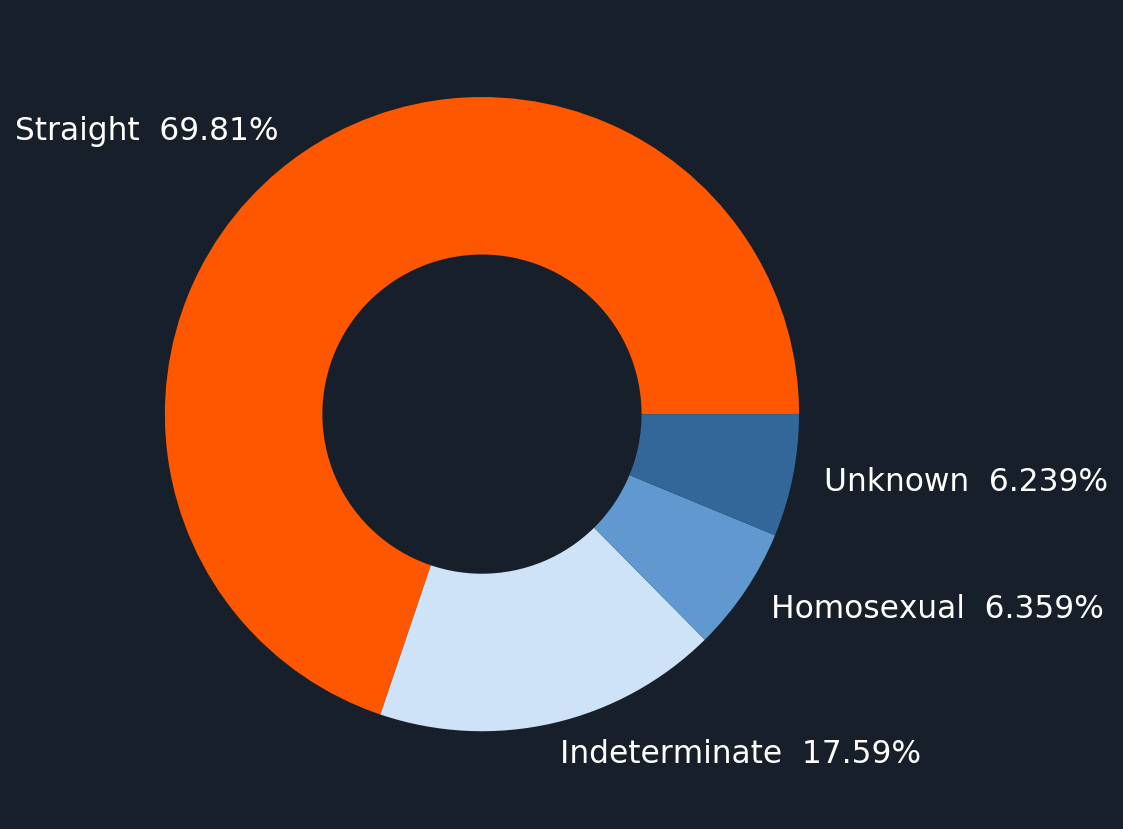

In [7]:
plt.rcParams['figure.facecolor'] = '#17202a'
# Create a circle for the center orf the plot
plt.figure(figsize=(8,7), dpi=150)
plt.rcParams['figure.facecolor'] = '#17202a'

circle=plt.Circle( (0,0), 0.5, color='#17202a')

# Give color names
plt.pie(vals_so, labels=labels_so, 
        colors=['#ff5700','#cee3f8','#5f99cf','#336699'],
       textprops={'color':"w",
                 'size':15})

p=plt.gcf()
p.gca().add_artist(circle)
plt.show()

Plot above shows the proportion of posts based on sexual orientation. **69.81%** of the posts were by users looking for the opposite sex.

#### Analysis on posts per gender

In [8]:
df1['Sex'].value_counts(normalize=True)*100

M          69.934662
F          23.826586
Unknown     6.238752
Name: Sex, dtype: float64

In [9]:
sx_so = df1['Sex'].value_counts(normalize=True)*100

sx = {}
sx['Male'] = sx_so[0]
sx['Female'] = sx_so[1]
sx['Unknown'] = sx_so[2]

In [10]:
labels_sx = []
vals_sx = []
for i,j in sx.items():
    labels_sx.append(f'{i} {j: .4}%')
    vals_sx.append(j)

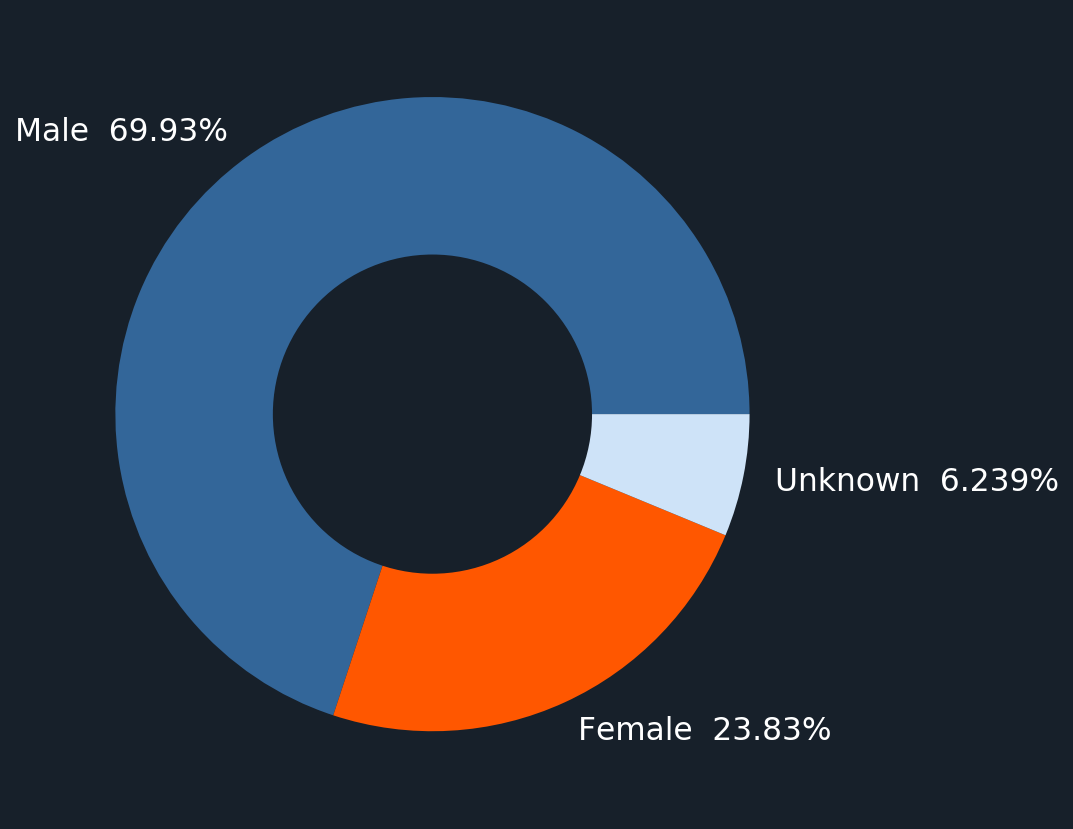

In [11]:
plt.rcParams['figure.facecolor'] = '#17202a'

# Create a circle for the center orf the plot
plt.figure(figsize=(8,7), dpi=150)
plt.rcParams['figure.facecolor'] = '#17202a'

circle=plt.Circle( (0,0), 0.5, color='#17202a')

# Give color names
plt.pie(vals_sx, labels=labels_sx, 
        colors=['#336699','#ff5700','#cee3f8'],
       textprops={'color':"w",
                 'size':15})

p=plt.gcf()
p.gca().add_artist(circle)
plt.show()

Plot above shows the proportion of posts based on gender. **69.93%** of the submissions were posted by males.

#### Age distribution

In [12]:
age_dist = list(df1[df1['Age'] != 0]['Age'])

In [13]:
c = collections.Counter(age_dist)
c = sorted(c.items())
age_ = [i[0] for i in c]
age_freq =[i[1] for i in c]

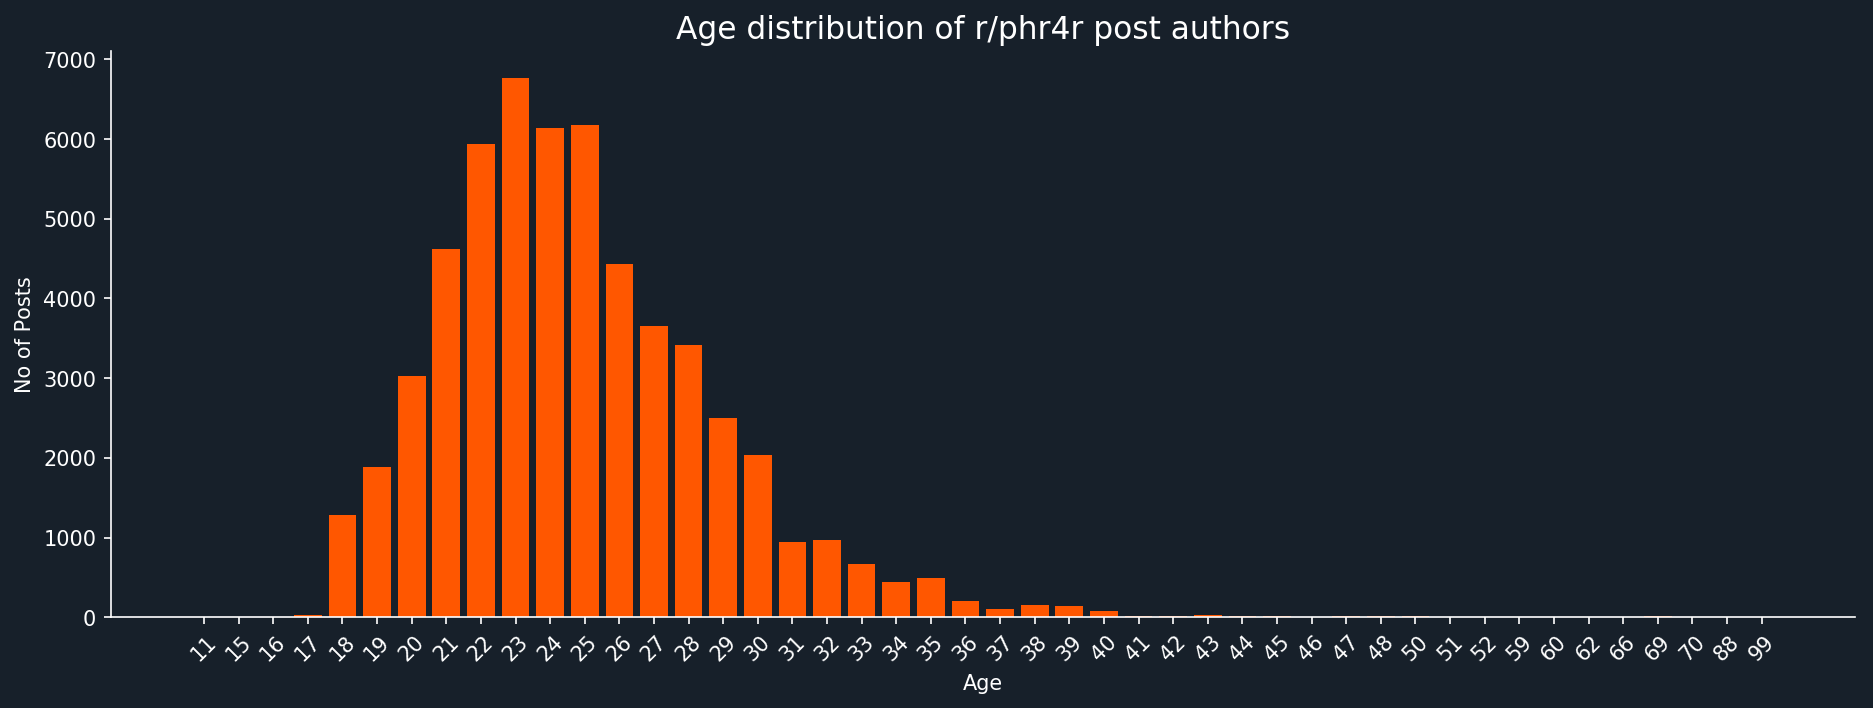

In [14]:
f, ax = plt.subplots(figsize=(15,5), dpi=150)
ax.set_facecolor('#17202a')

index = np.arange(len(age_))

plt.bar(index, age_freq, color='#ff5700')
plt.xlabel('Age', fontsize=10)
plt.ylabel('No of Posts', fontsize=10)
plt.xticks(index, age_, fontsize=10, rotation=45)
title = plt.title('Age distribution of r/phr4r post authors', fontsize=15)
plt.setp(title, color='white')


ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.xaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='y', colors='white')


plt.show()

Get the IQR and subsequently the outliers

In [15]:
q75, q25 = np.percentile(age_dist, [75 ,25])

iqr = q75 - q25

ub = q75 + 1.5*iqr #upperbound
lb = q25 - 1.5*iqr #lowerbound

print(f'upperbound {ub} y/o')
print(f'lowerbound {lb} y/o')

upperbound 34.5 y/o
lowerbound 14.5 y/o


In [16]:
outliers=[]
for i in age_:
    if i < lb or i > ub:
        outliers.append(i)

In [17]:
c_o = collections.Counter(outliers)
c_o = sorted(c_o.items())
age_o = [i[0] for i in c_o]
age_freq_o =[i[1] for i in c_o]

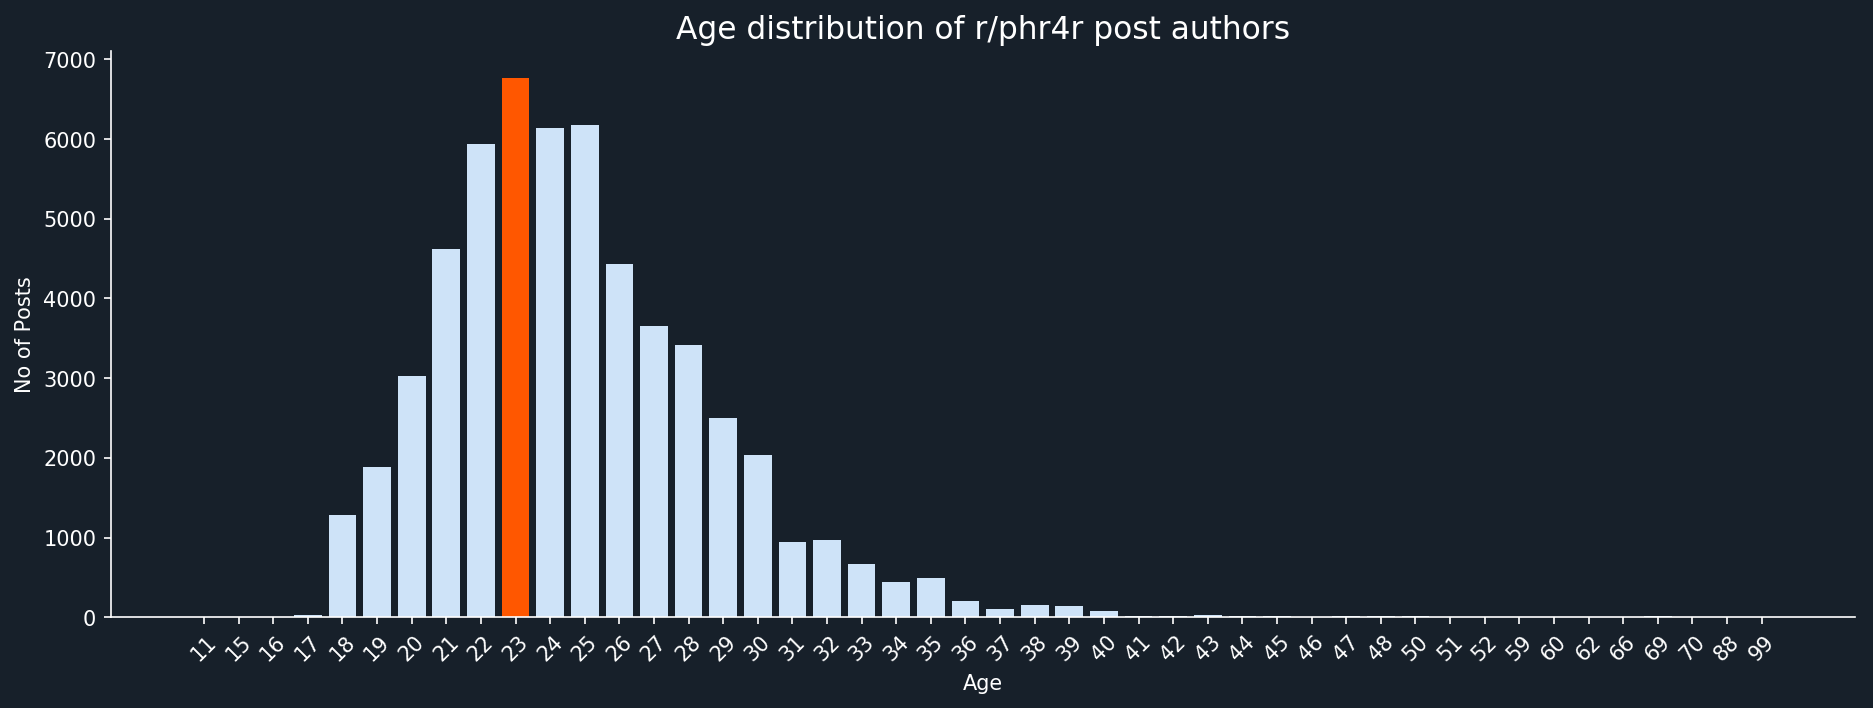

In [18]:
f, ax = plt.subplots(figsize=(15,5), dpi=150)
ax.set_facecolor('#17202a')

index = np.arange(len(age_))

plt.bar(index, age_freq, color='#cee3f8')
plt.bar(9, 6767, color='#ff5700')


plt.xlabel('Age', fontsize=10)
plt.ylabel('No of Posts', fontsize=10)
plt.xticks(index, age_, fontsize=10, rotation=45)
title = plt.title('Age distribution of r/phr4r post authors', fontsize=15)
plt.setp(title, color='white')


ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.xaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='y', colors='white')


plt.show()

Given the age distribution of the users in the r/phr4r subreddit seen above, it is apparent that the distribution is **left-skewed** with most of the users being of **23-year-old** users. 

The left-skewed distribution illustrates that the users are **15 to 35 years old**, which is also supported by the age distribution’s **interquartile range**.

In [19]:
df_23 = df1[df1.Age == 23]
df_23.head()

Age Sex Sexual Orientation  \
3    23   M           Straight   
5    23   M      Indeterminate   
15   23   M           Straight   
16   23   M         Homosexual   
19   23   M           Straight   

                                             Word Set  
3   {come, new, reply, time, girlfriend, inbox, ta...  
5                                      {area, españa}  
15        {approach, lookig, fwb, fetish, woman, age}  
16  {katipunan, marikina, mind, buddy, pasig, area...  
19  {reddit, r, killer, lurker, tress, discover, t...

In [20]:
age_23 = df_23['Sex'].value_counts(normalize=True)*100
age_23

M          68.834048
F          27.441998
Unknown     3.723954
Name: Sex, dtype: float64

In [21]:
gen=[]
prop_gen=[]
for i,j in age_23.items():
    gen.append(i)
    prop_gen.append(j)

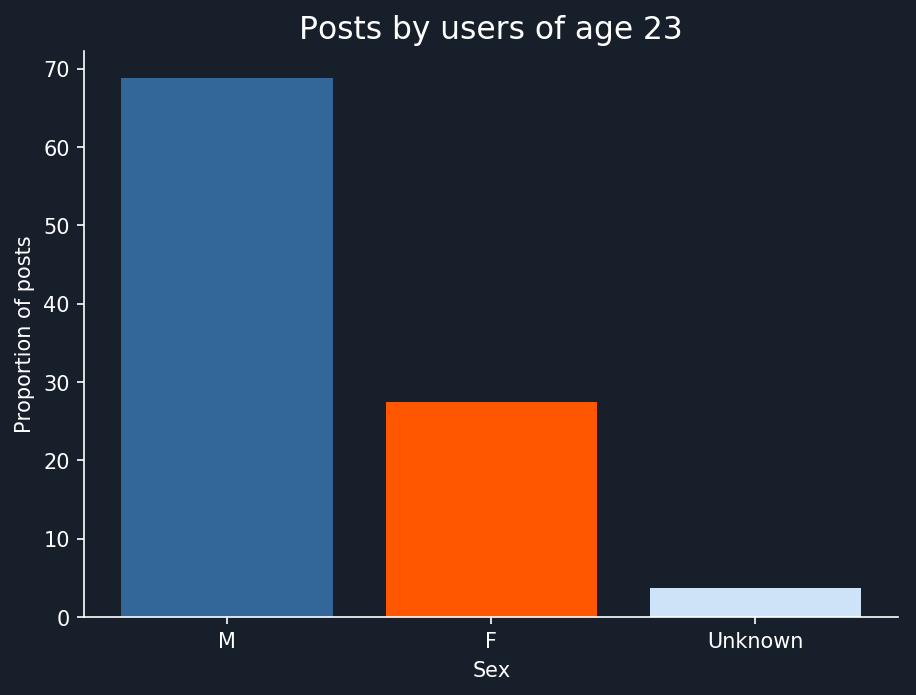

In [22]:
f, ax = plt.subplots(figsize=(7,5), dpi=150)
ax.set_facecolor('#17202a')

plt.bar(gen, prop_gen, color=['#336699','#ff5700','#cee3f8'])

plt.xlabel('Sex', fontsize=10)
plt.ylabel('Proportion of posts', fontsize=10)
title = plt.title('Posts by users of age 23', fontsize=15)
plt.setp(title, color='white')

ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.xaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='y', colors='white')


plt.show()

#### Age distribution between straight and homosexual

In [23]:
df_nz = df1[df1['Age'] != 0]
df_str = df_nz[df_nz['Sexual Orientation'] == 'Straight']
df_homo = df_nz[df_nz['Sexual Orientation'] == 'Homosexual']
df_ind = df_nz[df_nz['Sexual Orientation'] == 'Indeterminate']
df_unkwn = df_nz[df_nz['Sexual Orientation'] == 'Unknown']

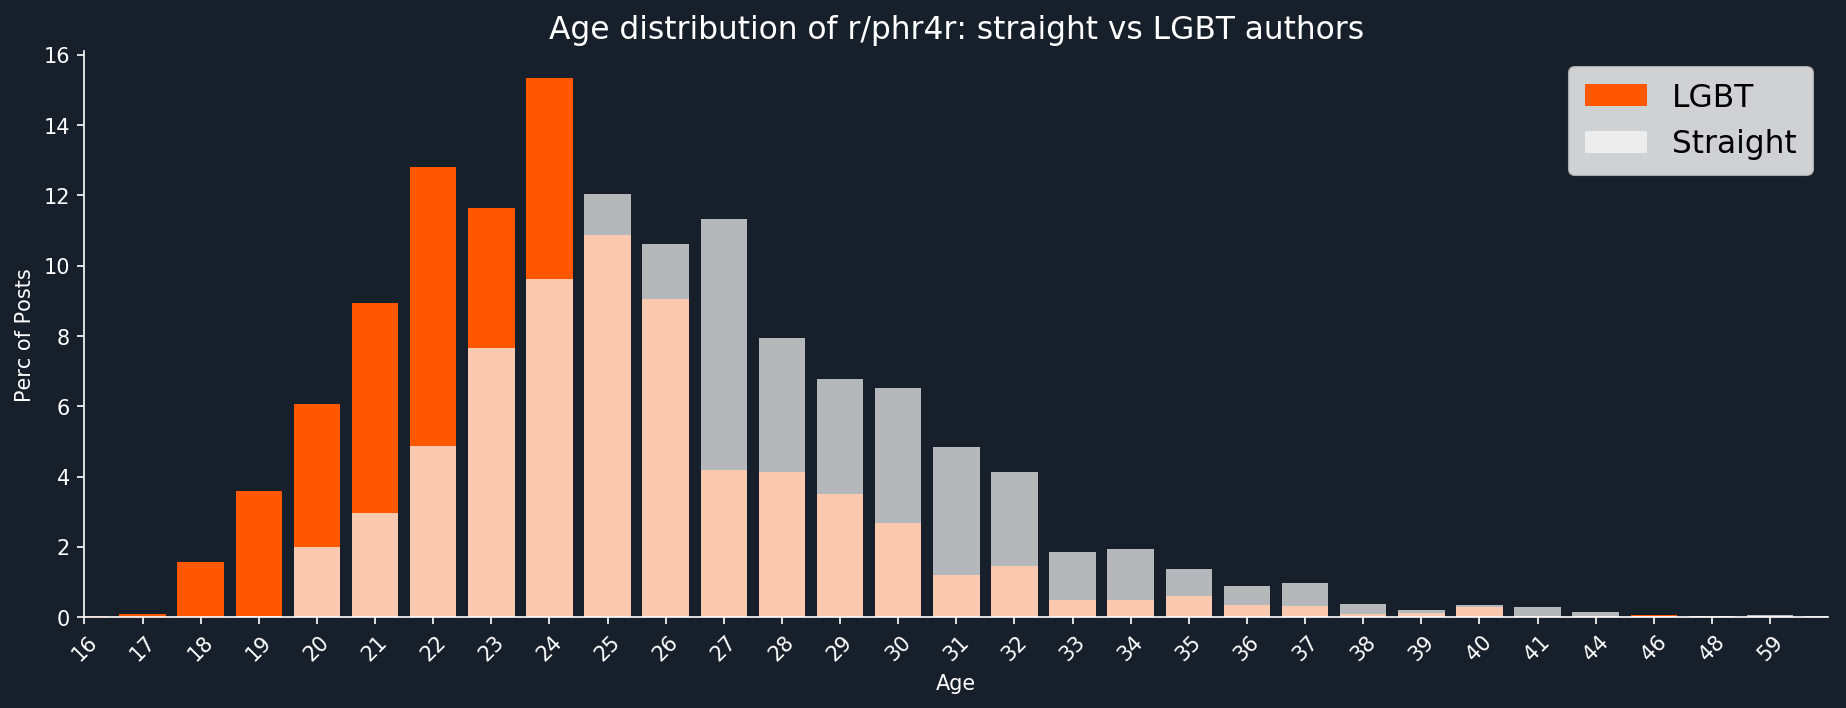

In [86]:
f, ax = plt.subplots(figsize=(15,5), dpi=150)
ax.set_facecolor('#17202a')

#homo
age_dist = list(df_homo['Age'])
c = collections.Counter(age_dist)
c = sorted(c.items())
age_ = [i[0] for i in c]
age_freq =[i[1] for i in c]
index = np.arange(len(age_))
plt.bar(index, (age_freq/np.sum(age_freq))*100, color='#ff5700',
        label='LGBT') #homo


#straight
age_dist_s = list(df_str['Age'])
c_s = collections.Counter(age_dist_s)
c_s = sorted(c_s.items())
age_s = [i[0] for i in c_s]
age_freq_s =[i[1] for i in c_s]
index_s = np.arange(len(age_s))
plt.bar(index_s, (age_freq_s/np.sum(age_freq_s))*100, color='#fafafa',
        alpha=0.7, label='Straight') #straight


plt.xlabel('Age', fontsize=10)
plt.ylabel('Perc of Posts', fontsize=10)
plt.xticks(index, age_, fontsize=10, rotation=45)
title = plt.title('Age distribution of r/phr4r: straight vs LGBT authors'
                  , fontsize=15)
plt.setp(title, color='white')

ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.xaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='y', colors='white')
ax.set_xlim(0, len(age_))
ax.legend(borderpad=.5, labelspacing=.5, fontsize=15)

plt.show()

Plot above shows age distribution of each sexual orientation. Interestingly, **homosexuals tend to post at a younger age than straight redditors**.

The generally younger population of LGBTQI+ may be in part due to the **anonymity granted by the platform**: users may simply be **exploring bisexual curiosities** or other things that would otherwise stigmatize them if expressed through other media.

Moreover, the comparative age distribution between the straight and homosexual users is indicative of the **homosexuals being more active on the platform at a younger age** whereas **active users that identify to be straight users tend to be active on the platform at a much latter age**. This observation is supported by a study by Barcz, M, et al., in 2019 which emphasized that **online anonymity** similar to what Reddit features **enhances self-expression and cultivates confidence in self-identification** especially in contrast to hostile environments similar to the prejudices and social constructs that the LGBTQI+ community faces in the Philippines. Given this Reddit platform, the youth of the LGBTQI+ community are provided with an avenue for them to openly interact and seek partners and peers without the worry of social dynamics and unjust playing into place.

#### Age distribution between genders

In [25]:
df_nz = df1[df1['Age'] != 0]

df_f = df_nz[df_nz.Sex == 'F']
df_m = df_nz[df_nz.Sex == 'M']
df_u = df_nz[df_nz.Sex == 'Unknown']

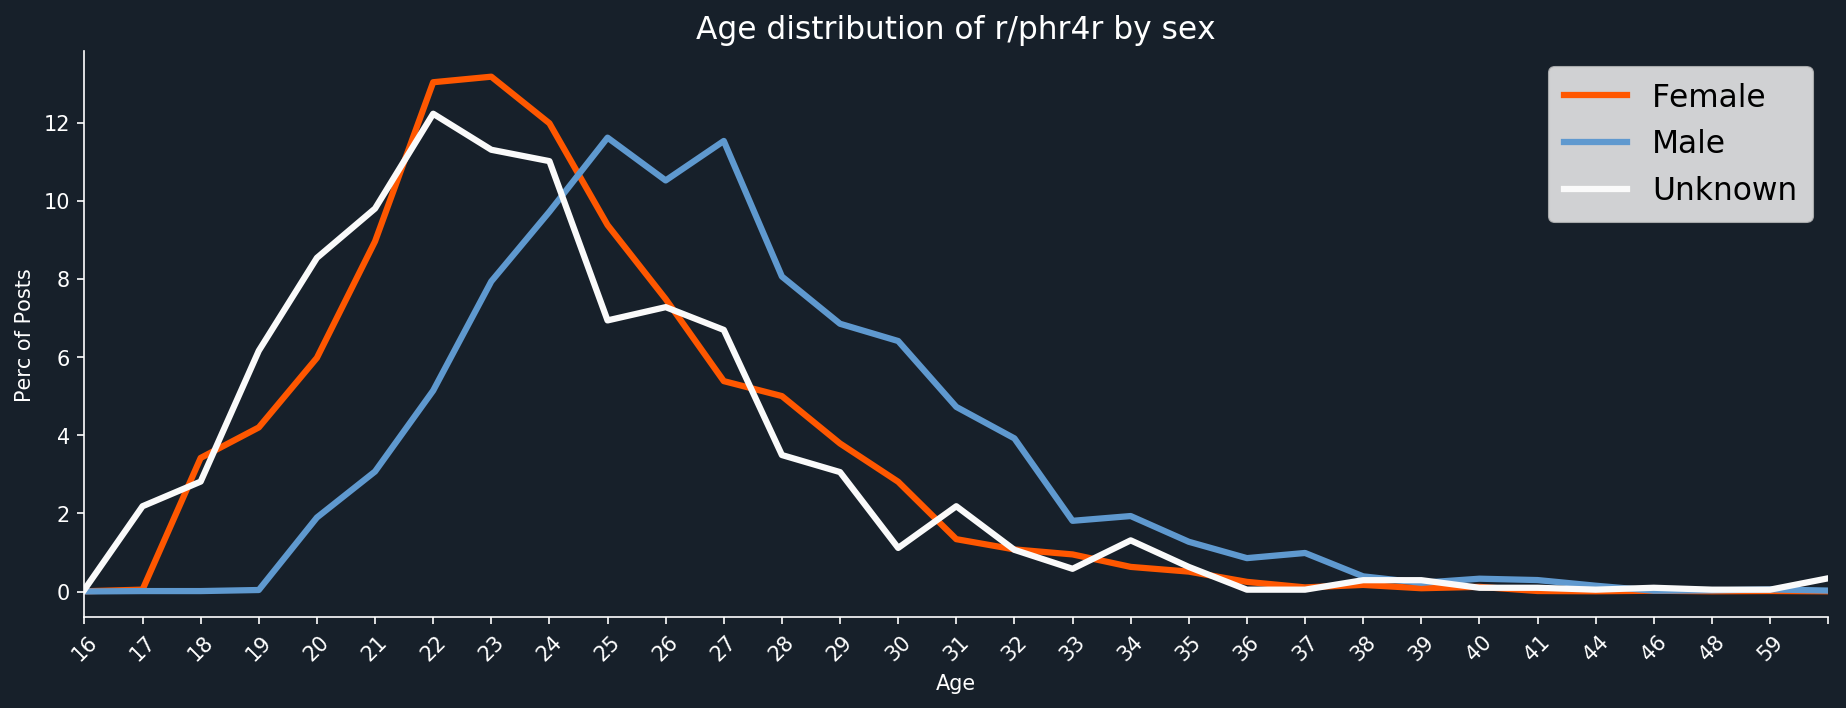

In [26]:
f, ax = plt.subplots(figsize=(15,5), dpi=150)
ax.set_facecolor('#17202a')

#female
age_dist_f = list(df_f['Age'])
c_f = collections.Counter(age_dist_f)
c_f = sorted(c_f.items())
age_f = [i[0] for i in c_f]
age_freq_f =[i[1] for i in c_f]
index = np.arange(len(age_f))
plt.plot(index, (age_freq_f/np.sum(age_freq_f))*100, color='#ff5700',
        label='Female', linewidth=3)

#male
age_dist_m = list(df_m['Age'])
c_m = collections.Counter(age_dist_m)
c_m = sorted(c_m.items())
age_m = [i[0] for i in c_m]
age_mreq_m =[i[1] for i in c_m]
index = np.arange(len(age_m))
plt.plot(index, (age_mreq_m/np.sum(age_mreq_m))*100, color='#5f99cf',
        label='Male', linewidth=3)

#unknown
age_dist_u = list(df_u['Age'])
c_u = collections.Counter(age_dist_u)
c_u = sorted(c_u.items())
age_u = [i[0] for i in c_u]
age_ureq_u =[i[1] for i in c_u]
index = np.arange(len(age_u))
plt.plot(index, (age_ureq_u/np.sum(age_ureq_u))*100, color='#fafafa',
        label='Unknown', linewidth=3)


plt.xlabel('Age', fontsize=10)
plt.ylabel('Perc of Posts', fontsize=10)
plt.xticks(index, age_, fontsize=10, rotation=45)
title = plt.title('Age distribution of r/phr4r by sex'
                  , fontsize=15)
plt.setp(title, color='white')

ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.xaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='y', colors='white')
ax.set_xlim(0, len(age_))
ax.legend(borderpad=.5, labelspacing=.5, fontsize=15)

plt.show()

Plot above shows age distribution by gender. We can see that **female authors tend to be younger than males**.

#### Distribution by gender and sexual orientation on different time intervals

In [30]:
with open('df_all_cols.pkl', 'rb') as pkl:
    df_date  = pickle.load(pkl)

In [32]:
df_date.head()

Age Sex Sexual Orientation  \
0    0   M         Homosexual   
1    0   M           Straight   
2   30   M           Straight   
3   23   M           Straight   
4   30   M           Straight   

                                            Word Set subreddit  created_utc  \
0      {bi, age, sta, mesa, place, fun, manila, old}     phr4r   1451891616   
1                                {hohol, drink, nsa}     phr4r   1451950820   
2                               {shaw, movie, chill}     phr4r   1452053372   
3  {come, new, reply, time, girlfriend, inbox, ta...     phr4r   1452065137   
4                      {hangout, laguna, pablo, san}     phr4r   1452248658   

        author                                              title  \
0        EdWao                              [m4m] looking for FUN   
1    [deleted]     [M4F] Let's have a drink? [HOHOL/NSA/Anything]   
2    [deleted]                     30 [M4F] Shaw, Movie and chill   
3  ThreesomePH  23 [M4F] Manila area. Actually looking for a t...   
4    [deleted]                30 [M4F] San Pablo Laguna, hangout?   

                                            selftext  ups  downs  score  \
0  Hey. I'm 18 bi m from Sta. Mesa Manila. Lookin...  2.0    0.0      2   
1                                          [removed]  1.0    0.0      1   
2                                          [deleted]  2.0    0.0      2   
3  So my girlfriend and I want to try something n...  7.0    0.0      7   
4                                          [deleted]  1.0    0.0      1   

   num_comments                                              texts  \
0             8  [m4m] looking for FUN\nHey. I'm 18 bi m from S...   
1             0  [M4F] Let's have a drink? [HOHOL/NSA/Anything]...   
2             0          30 [M4F] Shaw, Movie and chill\n[deleted]   
3             8  23 [M4F] Manila area. Actually looking for a t...   
4             0     30 [M4F] San Pablo Laguna, hangout?\n[deleted]   

                 date  
0 2016-01-04 07:13:36  
1 2016-01-04 23:40:20  
2 2016-01-06 04:09:32  
3 2016-01-06 07:25:37  
4 2016-01-08 10:24:18

In [59]:
df_date_ = df_date[['Sex','Sexual Orientation','date']]
df_date_['wk_day'] = df_date_['date'].dt.dayofweek
df_date_['hr'] = df_date_['date'].dt.hour
df_date_.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Sex Sexual Orientation                date  wk_day  hr
0   M         Homosexual 2016-01-04 07:13:36       0   7
1   M           Straight 2016-01-04 23:40:20       0  23
2   M           Straight 2016-01-06 04:09:32       2   4
3   M           Straight 2016-01-06 07:25:37       2   7
4   M           Straight 2016-01-08 10:24:18       4  10

In [73]:
d_s = df_date_[df_date_['Sexual Orientation'] == 'Homosexual']
d_h = df_date_[df_date_['Sexual Orientation'] == 'Straight']

d_f = df_date_[df_date_.Sex == 'F']
d_m = df_date_[df_date_.Sex == 'M']
d_u = df_date_[df_date_.Sex == 'Unknown']

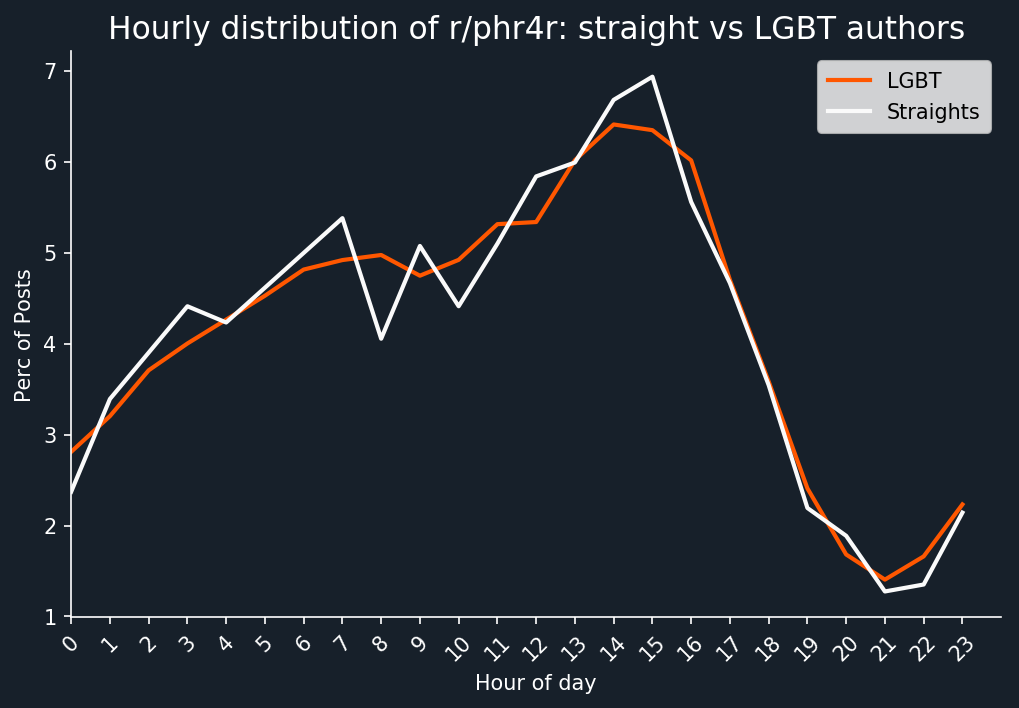

In [87]:
f, ax = plt.subplots(figsize=(8,5), dpi=150)
ax.set_facecolor('#17202a')

#homo
h_hr_dist = list(d_h['hr'])
c = collections.Counter(h_hr_dist)
c = sorted(c.items())
h_hr_ = [i[0] for i in c]
h_hr_freq =[i[1] for i in c]
index = np.arange(len(h_hr_))
plt.plot(index, (h_hr_freq/np.sum(h_hr_freq))*100, color='#ff5700',
        label='LGBT',linewidth=2)


#straight
s_hr_dist = list(d_s['hr'])
c_ = collections.Counter(s_hr_dist)
c_ = sorted(c_.items())
s_hr_ = [i[0] for i in c_]
s_hr_freq =[i[1] for i in c_]
index = np.arange(len(s_hr_))
plt.plot(index, (s_hr_freq/np.sum(s_hr_freq))*100, color='#fafafa',
        label='Straights',linewidth=2)


plt.xlabel('Hour of day', fontsize=10)
plt.ylabel('Perc of Posts', fontsize=10)
plt.xticks(index, h_hr_, fontsize=10, rotation=45)
title = plt.title('Hourly distribution of r/phr4r: straight vs LGBT authors'
                  , fontsize=15)
plt.setp(title, color='white')

ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.xaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='y', colors='white')
ax.set_xlim(0, len(h_hr_))
ax.legend(borderpad=.5, labelspacing=.5, fontsize=10)

plt.show()

We can see a huge spike at **2-3PM** on number of posts for both straight and homosexuals.

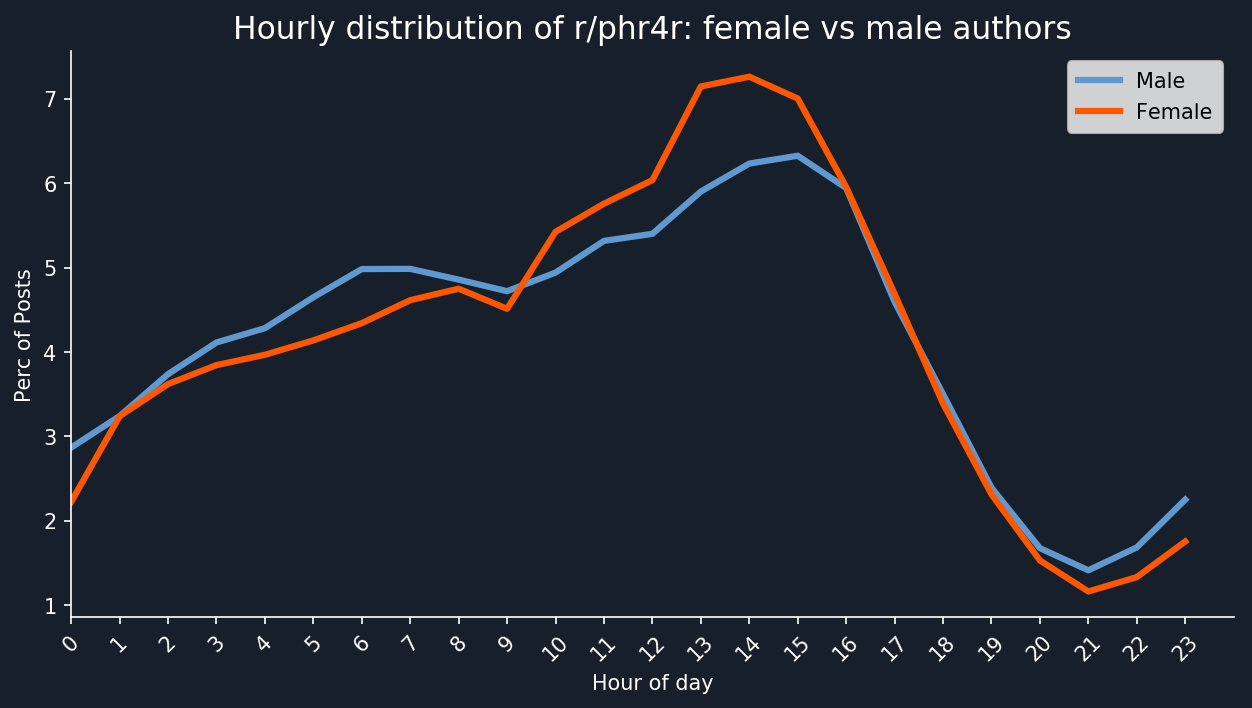

In [79]:
f, ax = plt.subplots(figsize=(10,5), dpi=150)
ax.set_facecolor('#17202a')

#male
age_dist_m = list(d_m['hr'])
c_m = collections.Counter(age_dist_m)
c_m = sorted(c_m.items())
age_m = [i[0] for i in c_m]
age_mreq_m =[i[1] for i in c_m]
index = np.arange(len(age_m))
plt.plot(index, (age_mreq_m/np.sum(age_mreq_m))*100, color='#5f99cf',
        label='Male', linewidth=3)

#female
age_dist_f = list(d_f['hr'])
c_f = collections.Counter(age_dist_f)
c_f = sorted(c_f.items())
age_f = [i[0] for i in c_f]
age_freq_f =[i[1] for i in c_f]
index = np.arange(len(age_f))
plt.plot(index, (age_freq_f/np.sum(age_freq_f))*100, color='#ff5700',
        label='Female', linewidth=3)


plt.xlabel('Hour of day', fontsize=10)
plt.ylabel('Perc of Posts', fontsize=10)
plt.xticks(index, h_hr_, fontsize=10, rotation=45)
title = plt.title('Hourly distribution of r/phr4r: female vs male authors'
                  , fontsize=15)
plt.setp(title, color='white')

ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.xaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='y', colors='white')
ax.set_xlim(0, len(h_hr_))
ax.legend(borderpad=.5, labelspacing=.5, fontsize=10)

plt.show()

Same results for both genders: **2-3PM**

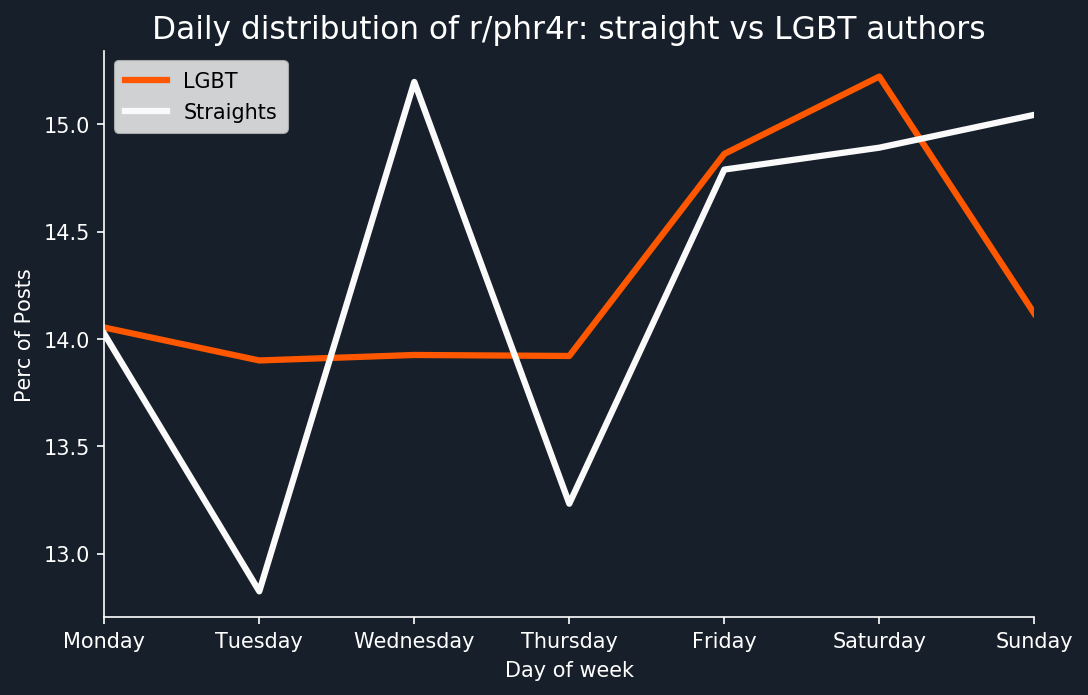

In [89]:
f, ax = plt.subplots(figsize=(8,5), dpi=150)
ax.set_facecolor('#17202a')

#homo
h_wk_dist = list(d_h['wk_day'])
c = collections.Counter(h_wk_dist)
c = sorted(c.items())
h_wk_ = [i[0] for i in c]
h_wk_freq =[i[1] for i in c]
index = np.arange(len(h_wk_))
plt.plot(index, (h_wk_freq/np.sum(h_wk_freq))*100, color='#ff5700',
        label='LGBT',linewidth=3)


#straight
s_wk_dist = list(d_s['wk_day'])
c_ = collections.Counter(s_wk_dist)
c_ = sorted(c_.items())
s_wk_ = [i[0] for i in c_]
s_wk_freq =[i[1] for i in c_]
index = np.arange(len(s_wk_))
plt.plot(index, (s_wk_freq/np.sum(s_wk_freq))*100, color='#fafafa',
        label='Straights', linewidth=3)

wk_day_list = ['Monday','Tuesday','Wednesday',
               'Thursday','Friday','Saturday','Sunday']

plt.xlabel('Day of week', fontsize=10)
plt.ylabel('Perc of Posts', fontsize=10)
plt.xticks(index, wk_day_list, fontsize=10)
title = plt.title('Daily distribution of r/phr4r: straight vs LGBT authors'
                  , fontsize=15)
plt.setp(title, color='white')

ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.xaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='y', colors='white')
ax.set_xlim(0, len(h_wk_)-1)
ax.legend(borderpad=.5, labelspacing=.5, fontsize=10)

plt.show()

For **homosexuals**, there is a **steady number of posts during the weekday** then starts to **go up on the end of the week, peaking on Saturday**, and finally **goes down again on Sunday**.

However, for **straights**, the number of posts **fluctuates**, but has the **highest number during Wednesdays**.

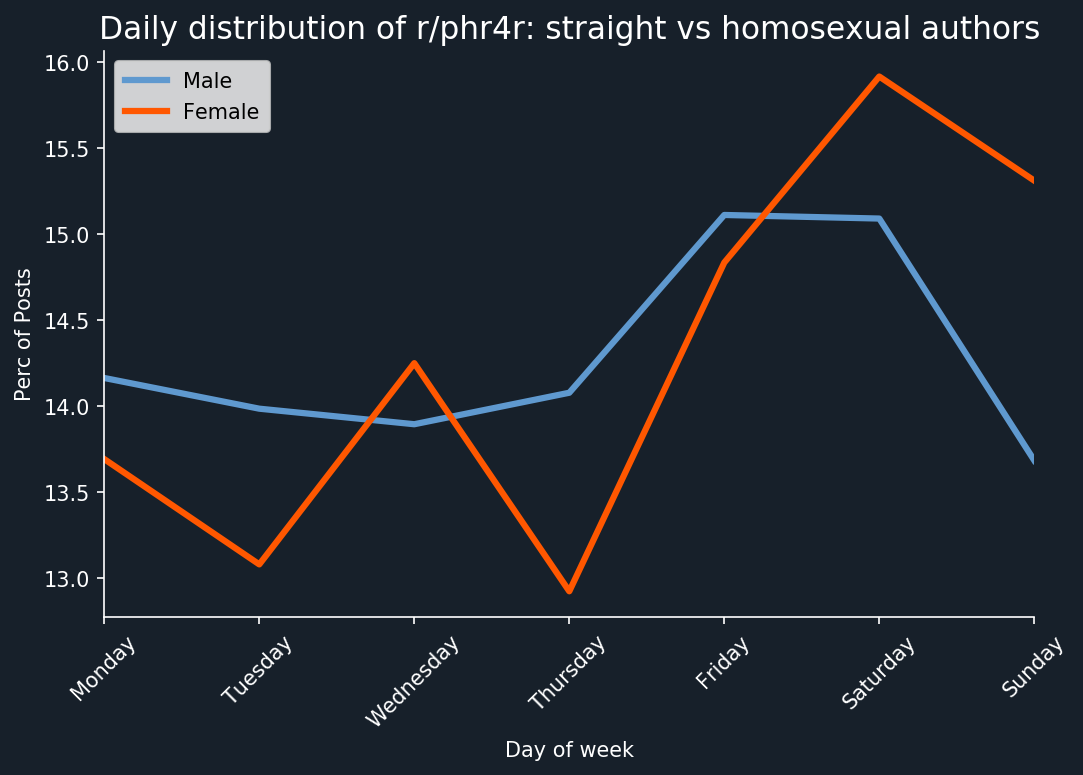

In [80]:
f, ax = plt.subplots(figsize=(8,5), dpi=150)
ax.set_facecolor('#17202a')

#male
age_dist_m = list(d_m['wk_day'])
c_m = collections.Counter(age_dist_m)
c_m = sorted(c_m.items())
age_m = [i[0] for i in c_m]
age_mreq_m =[i[1] for i in c_m]
index = np.arange(len(age_m))
plt.plot(index, (age_mreq_m/np.sum(age_mreq_m))*100, color='#5f99cf',
        label='Male', linewidth=3)

#female
age_dist_f = list(d_f['wk_day'])
c_f = collections.Counter(age_dist_f)
c_f = sorted(c_f.items())
age_f = [i[0] for i in c_f]
age_freq_f =[i[1] for i in c_f]
index = np.arange(len(age_f))
plt.plot(index, (age_freq_f/np.sum(age_freq_f))*100, color='#ff5700',
        label='Female', linewidth=3)

wk_day_list = ['Monday','Tuesday','Wednesday',
               'Thursday','Friday','Saturday','Sunday']

plt.xlabel('Day of week', fontsize=10)
plt.ylabel('Perc of Posts', fontsize=10)
plt.xticks(index, wk_day_list, fontsize=10, rotation=45)
title = plt.title('Daily distribution of r/phr4r: straight vs homosexual authors'
                  , fontsize=15)
plt.setp(title, color='white')

ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.xaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='y', colors='white')
ax.set_xlim(0, len(h_wk_)-1)
ax.legend(borderpad=.5, labelspacing=.5, fontsize=10)

plt.show()

For **males**, there is a **steady number of posts during the weekday** then starts to **go up on the end of the week, peaking on Friday/Saturday**, and finally **goes down again on Sunday**.

However, for **females**, the number of posts **fluctuates**, but **peaks highest during Saturdays**.

## 4. Profiling

For this study, we aim to compare the behavior of each sexual orientation, straight and homosexuals, by performing analysis on each separately to discover underlying insights that may differ or be similar to both classes.

In [2]:
import pickle
import pandas as pd

#### Load data to dataframe

In [3]:
with open('df_all_cols.pkl', 'rb') as f:
    df_all_cols = pickle.load(f)

#### Create dataframes for each sexual orientation

In [4]:
df_all_cols['Sexual Orientation'].unique()

array(['Homosexual', 'Straight', 'Indeterminate', 'Unknown'], dtype=object)

In [5]:
df_all_cols_hom = df_all_cols[df_all_cols['Sexual Orientation']=='Homosexual']
df_all_cols_str = df_all_cols[df_all_cols['Sexual Orientation']=='Straight']

In [277]:
df_all_cols_hom.head(2)

Age Sex Sexual Orientation  \
0    0   M         Homosexual   
8    0   M         Homosexual   

                                            Word Set subreddit  created_utc  \
0      {old, mesa, sta, manila, bi, age, fun, place}     phr4r   1451891616   
8  {experiment, complicated, lad, manila, make, n...     phr4r   1452748498   

      author                                    title  \
0      EdWao                    [m4m] looking for FUN   
8  toohot888  [m4m] Bi-curios lad here. Near Mendiola   

                                            selftext  ups  downs  score  \
0  Hey. I'm 18 bi m from Sta. Mesa Manila. Lookin...  2.0    0.0      2   
8  I have a complicated situation. I made a new r...  3.0    0.0      3   

   num_comments                                              texts  \
0             8  [m4m] looking for FUN\nHey. I'm 18 bi m from S...   
8             3  [m4m] Bi-curios lad here. Near Mendiola\nI hav...   

                 date  
0 2016-01-04 07:13:36  
8 2016-01-14 05:14:58

In [278]:
df_all_cols_str.head(2)

Age Sex Sexual Orientation              Word Set subreddit  created_utc  \
1    0   M           Straight   {hohol, nsa, drink}     phr4r   1451950820   
2   30   M           Straight  {movie, chill, shaw}     phr4r   1452053372   

      author                                           title   selftext  ups  \
1  [deleted]  [M4F] Let's have a drink? [HOHOL/NSA/Anything]  [removed]  1.0   
2  [deleted]                  30 [M4F] Shaw, Movie and chill  [deleted]  2.0   

   downs  score  num_comments  \
1    0.0      1             0   
2    0.0      2             0   

                                               texts                date  
1  [M4F] Let's have a drink? [HOHOL/NSA/Anything]... 2016-01-04 23:40:20  
2          30 [M4F] Shaw, Movie and chill\n[deleted] 2016-01-06 04:09:32

## 5. Data Mining

To further discover hidden insights on the posts and demographics of phr4r submissions, we will use Frequent Itemset Mining (FIM) and Association Rule Mining (ARM) wherein each post is treated as a transaction, and the words extracted from the post (verbs, adjectives, and nouns) are their items.

All methods below were done using Spark.

### a. Frequent Itemset Mining

Frequent Itemset Mining is a subset of data mining that attempts to discover interesting and useful patterns in a transaction database. (Fournier‐Viger, 2016) Groups of items that appear together frequently (itemsets) based on a support level is generated. Support is computed as the total count of how many of the itemsets appear in the transactions (N). Relative support is expressed as a percent of the total number of transactions in the database (N) that cover a candidate itemset (X). Confidence is the likeliness of occurrence of consequent on the cart given that the cart already has the antecedents. This could be computed by the support of candidate itemsets (X and Y) divided by the support of candidate (X).  

#### <center>𝑋 𝑠𝑢𝑝 (𝑋 ∪ 𝑌) 𝑠𝑢𝑝(𝑋) = 𝑁, 𝑐𝑜𝑛𝑓(𝑋 → 𝑌) = 𝑠𝑢𝑝(𝑋)</center>

The package used for the FIM analysis is PyFIM. PyFIM is an extension module that makes several frequent itemset mining implementations such as Apriori, Eclat, FP-growth, etc., available as functions in Python. Finally, there is a function arules which can be used to generate the association rules. (http://www.borgelt.net/pyfim.html)  

For the analysis, FP-growth was chosen as the algorithm. FP-growth is a pattern-growth algorithm that scans a database for itemsets (with an identified minimum support) and creating a projected database from the itemsets that satisfy the aforementioned condition (Fournier‐Viger, 2016). This approach is based on divide and conquer strategy for producing the frequent item sets. A summary of the algorithm as pseudo code is shown below:
<img src="img1.PNG">
<center>Figure 3 – FP-growth Algorithm Pseudo-code (Fournier-Viger, 2018)</center>

The following parameters were used in the implementation of FP-growth (fim.fpgrowth):  

`Straight:`
```python
FPGrowth(itemsCol='Word Set', minSupport=0.001, minConfidence=0)
```
<pre>𝑠𝑢𝑝 = 0.1, 𝑐𝑜𝑛𝑓 = 0</pre>


`Homosexual:`
```python
FPGrowth(itemsCol='Word Set', minSupport=0.002, minConfidence=0)
```
<pre>𝑠𝑢𝑝 = 0.2, 𝑐𝑜𝑛𝑓 = 0</pre>


𝑤h𝑒𝑟𝑒 𝑠𝑢𝑝 𝑖𝑠 𝑡h𝑒 𝑚𝑖𝑛𝑖𝑚𝑢𝑚 𝑟𝑒𝑙𝑎𝑡𝑖𝑣𝑒 𝑠𝑢𝑝𝑝𝑜𝑟𝑡, 𝑎𝑛𝑑 𝑐𝑜𝑛𝑓 𝑖𝑠 𝑡h𝑒 𝑚𝑖𝑛𝑖𝑚𝑢𝑚 𝑐𝑜𝑛𝑓𝑖𝑑𝑒𝑛𝑐𝑒 𝑜𝑓 𝑎𝑛 𝑎𝑠𝑠𝑜𝑐𝑖𝑎𝑡𝑖𝑜𝑛 𝑟𝑢𝑙𝑒

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

from pyspark.sql.functions import udf, desc
from pyspark.ml.fpm import FPGrowth

#### FIM for Straight orientation

In [6]:
df_s = df_all_cols_str[['Word Set']].reset_index()

df_s['Word Set'] = df_s['Word Set'].apply(lambda x: list(x))
df_s['no_items'] = df_s['Word Set'].apply(lambda x: len(x))

df_s = df_s[df_s['no_items'] > 0].drop(columns=['no_items'])

In [7]:
df_s.shape

(42226, 2)

In [8]:
df_s.head()

index                                           Word Set
0      1                                [hohol, nsa, drink]
1      2                               [movie, chill, shaw]
2      3  [girlfriend, buddy, try, manila, inbox, come, ...
3      4                      [san, pablo, laguna, hangout]
4      6  [redditor, nga, halong, sini, kag, iloilo, din...

In [9]:
dfs = spark.createDataFrame(df_s[['index', 'Word Set']])

In [279]:
dfs.show(5)

+-----+--------------------+
|index|            Word Set|
+-----+--------------------+
|    1| [hohol, nsa, drink]|
|    2|[movie, chill, shaw]|
|    3|[girlfriend, budd...|
|    4|[san, pablo, lagu...|
|    6|[redditor, nga, h...|
+-----+--------------------+
only showing top 5 rows



In [10]:
fpgrowth1 = FPGrowth(itemsCol='Word Set', minSupport=0.001, minConfidence=0)
fpgrowth_trained1 = fpgrowth1.fit(dfs)

In [11]:
freq_items_s = fpgrowth_trained1.freqItemsets
assoc_rules_s = fpgrowth_trained1.associationRules
conseqs_s = fpgrowth_trained1.transform(dfs)

In [12]:
no_items = udf(lambda x: len(x))
freq_itemsS = freq_items_s.withColumn('no_items', 
                                      no_items(freq_items_s['items']))

In [13]:
df_freq_itemsS = freq_itemsS.toPandas()
df_freq_itemsS['no_items'] = df_freq_itemsS['no_items'].astype('int')

In [14]:
df_freq_itemsS.shape

(82379, 3)

```python
with open('df_freq_items_str.pkl', 'wb') as f:
    pickle.dump(df_freq_itemsS, f)
```

#### Investigate frequent n-itemsets (less n+1-itemsets)

In [40]:
itemset1 = df_freq_itemsS[df_freq_itemsS['no_items']==1
                         ].sort_values(['freq', 'no_items'], ascending=False
                                      ).reset_index(drop=True)
itemset2 = df_freq_itemsS[df_freq_itemsS['no_items']==2
                         ].sort_values(['freq', 'no_items'], ascending=False
                                      ).reset_index(drop=True)
itemset3 = df_freq_itemsS[df_freq_itemsS['no_items']==3
                         ].sort_values(['freq', 'no_items'], ascending=False
                                      ).reset_index(drop=True)
itemset4 = df_freq_itemsS[df_freq_itemsS['no_items']==4
                         ].sort_values(['freq', 'no_items'], ascending=False
                                      ).reset_index(drop=True)
itemset5 = df_freq_itemsS[df_freq_itemsS['no_items']==5
                         ].sort_values(['freq', 'no_items'], ascending=False
                                      ).reset_index(drop=True)
itemset6 = df_freq_itemsS[df_freq_itemsS['no_items']==6
                         ].sort_values(['freq', 'no_items'], ascending=False
                                      ).reset_index(drop=True)

In [37]:
words1 = []
for i in itemset1.loc[:9, 'items'].values:
    words1 += i

words1_ = set(words1)
print(sorted(words1_), '\n', len(words1_))
print(sorted(set(words1)), '\n', len(words1))

['area', 'buddy', 'chat', 'fun', 'makati', 'manila', 'pm', 'qc', 'talk', 'time'] 
 10
['area', 'buddy', 'chat', 'fun', 'makati', 'manila', 'pm', 'qc', 'talk', 'time'] 
 10


In [40]:
words2 = []
for i in itemset2.loc[:12, 'items'].values:
    words2 += i

words2_ = set(words2) - words1_
print(sorted(words2_), '\n', len(words2_))
print(sorted(set(words2)), '\n', len(words2))

['fubu', 'fwb', 'good', 'like', 'metro', 'movie', 'need', 'thing', 'watch', 'work'] 
 10
['area', 'chat', 'fubu', 'fwb', 'good', 'like', 'manila', 'metro', 'movie', 'need', 'qc', 'talk', 'thing', 'time', 'watch', 'work'] 
 26


In [45]:
words3 = []
for i in itemset3.loc[:45, 'items'].values:
    words3 += i

words3_ = set(words3) - set(words2)
print(sorted(words3_), '\n', len(words3_))
print(sorted(set(words3)), '\n', len(words3))

['friend', 'love', 'make', 'meet', 'new', 'old', 'people', 'post', 'would', 'year'] 
 10
['chat', 'friend', 'good', 'like', 'love', 'make', 'meet', 'movie', 'new', 'old', 'people', 'post', 'talk', 'thing', 'time', 'watch', 'work', 'would', 'year'] 
 138


In [49]:
words4 = []
for i in itemset4.loc[:280, 'items'].values:
    words4 += i

words4_ = set(words4) - set(words3)
print(sorted(words4_), '\n', len(words4_))
print(sorted(set(words4)), '\n', len(words4))

['day', 'feel', 'life', 'lot', 'open', 'read', 'say', 'see', 'send', 'try'] 
 10
['chat', 'day', 'feel', 'friend', 'good', 'life', 'like', 'lot', 'love', 'make', 'meet', 'new', 'old', 'open', 'people', 'post', 'read', 'say', 'see', 'send', 'talk', 'thing', 'time', 'try', 'work', 'would', 'year'] 
 1124


In [51]:
words5 = []
for i in itemset5.loc[:800, 'items'].values:
    words5 += i

words5_ = set(words5) - set(words4)
print(sorted(words5_), '\n', len(words5_))
print(sorted(set(words5)), '\n', len(words5))

['ask', 'bit', 'com', 'comment', 'game', 'https', 'phrr', 'reddit', 'tell', 'thank', 'www'] 
 11
['ask', 'bit', 'chat', 'com', 'comment', 'day', 'feel', 'free', 'friend', 'game', 'good', 'https', 'life', 'like', 'lot', 'love', 'make', 'meet', 'new', 'old', 'open', 'people', 'phrr', 'post', 'read', 'reddit', 'say', 'see', 'talk', 'tell', 'thank', 'thing', 'think', 'time', 'work', 'would', 'www', 'year'] 
 4005


In [54]:
words6 = []
for i in itemset6.loc[:5000, 'items'].values:
    words6 += i

words6_ = set(words6) - set(words5)
print(sorted(words6_), '\n', len(words6_))
print(sorted(set(words6)), '\n', len(words6))

[] 
 0
['feel', 'friend', 'good', 'meet', 'new', 'people', 'post', 'talk', 'thing', 'time', 'work'] 
 36


#### FIM for Homosexual orientation

In [87]:
df_h = df_all_cols_hom[['Word Set']].reset_index()

df_h['Word Set'] = df_h['Word Set'].apply(lambda x: list(x))
df_h['no_items'] = df_h['Word Set'].apply(lambda x: len(x))

df_h = df_h[df_h['no_items'] > 0].drop(columns=['no_items'])

In [88]:
df_h.shape

(3824, 2)

In [89]:
df_h.head()

index                                           Word Set
0      0      [old, mesa, sta, manila, bi, age, fun, place]
1      8  [experiment, complicated, lad, manila, make, n...
2     11  [sure, ganun, individual, fondle, trade, talks...
3     16  [buddy, hang, bore, antipolo, area, available,...
4     57  [people, feel, redditor, rr, kik, local, free,...

In [90]:
dfh = spark.createDataFrame(df_h[['index', 'Word Set']])

In [91]:
dfh.show(5)

+-----+--------------------+
|index|            Word Set|
+-----+--------------------+
|    0|[old, mesa, sta, ...|
|    8|[experiment, comp...|
|   11|[sure, ganun, ind...|
|   16|[buddy, hang, bor...|
|   57|[people, feel, re...|
+-----+--------------------+
only showing top 5 rows



In [93]:
fpgrowth2 = FPGrowth(itemsCol='Word Set', minSupport=0.002, minConfidence=0)
fpgrowth_trained2 = fpgrowth2.fit(dfh)

In [94]:
freq_items_h = fpgrowth_trained2.freqItemsets
assoc_rules_h = fpgrowth_trained2.associationRules
conseqs_h = fpgrowth_trained2.transform(dfh)

In [95]:
no_items = udf(lambda x: len(x))
freq_itemsH = freq_items_h.withColumn('no_items', 
                                      no_items(freq_items_h['items']))

In [96]:
df_freq_itemsH = freq_itemsH.toPandas()
df_freq_itemsH['no_items'] = df_freq_itemsH['no_items'].astype('int')

In [97]:
df_freq_itemsH.shape

(14719, 3)

```python
with open('df_freq_items_hom.pkl', 'wb') as f:
    pickle.dump(df_freq_itemsH, f)
```

#### Investigate frequent n-itemsets (less n+1-itemsets)

In [25]:
itemset1 = df_freq_itemsH[df_freq_itemsH['no_items']==1
                         ].sort_values(['freq', 'no_items'], ascending=False
                                      ).reset_index(drop=True)
itemset2 = df_freq_itemsH[df_freq_itemsH['no_items']==2
                         ].sort_values(['freq', 'no_items'], ascending=False
                                      ).reset_index(drop=True)
itemset3 = df_freq_itemsH[df_freq_itemsH['no_items']==3
                         ].sort_values(['freq', 'no_items'], ascending=False
                                      ).reset_index(drop=True)
itemset4 = df_freq_itemsH[df_freq_itemsH['no_items']==4
                         ].sort_values(['freq', 'no_items'], ascending=False
                                      ).reset_index(drop=True)
itemset5 = df_freq_itemsH[df_freq_itemsH['no_items']==5
                         ].sort_values(['freq', 'no_items'], ascending=False
                                      ).reset_index(drop=True)

In [26]:
words1 = []
for i in itemset1.loc[:9, 'items'].values:
    words1 += i

words1_ = set(words1)
print(sorted(words1_), '\n', len(words1_))
print(sorted(set(words1)), '\n', len(words1))

['buddy', 'friend', 'fun', 'girl', 'interested', 'makati', 'manila', 'pm', 'qc', 'talk'] 
 10
['buddy', 'friend', 'fun', 'girl', 'interested', 'makati', 'manila', 'pm', 'qc', 'talk'] 
 10


In [27]:
words2 = []
for i in itemset2.loc[:12, 'items'].values:
    words2 += i

words2_ = set(words2) - words1_
print(sorted(words2_), '\n', len(words2_))
print(sorted(set(words2)), '\n', len(words2))

['bi', 'curious', 'first', 'like', 'message', 'send', 'telegram', 'time', 'try', 'would'] 
 10
['bi', 'curious', 'first', 'friend', 'girl', 'interested', 'like', 'message', 'pm', 'send', 'talk', 'telegram', 'time', 'try', 'would'] 
 26


In [31]:
words3 = []
for i in itemset3.loc[:25, 'items'].values:
    words3 += i

words3_ = set(words3) - set(words2)
print(sorted(words3_), '\n', len(words3_))
print(sorted(set(words3)), '\n', len(words3))

['feel', 'good', 'make', 'old', 'post', 'see', 'thing', 'think', 'work', 'year'] 
 10
['feel', 'friend', 'girl', 'good', 'interested', 'like', 'make', 'message', 'old', 'post', 'see', 'send', 'talk', 'telegram', 'thing', 'think', 'time', 'try', 'work', 'would', 'year'] 
 78


In [35]:
words4 = []
for i in itemset4.loc[:55, 'items'].values:
    words4 += i

words4_ = set(words4) - set(words3)
print(sorted(words4_), '\n', len(words4_))
print(sorted(set(words4)), '\n', len(words4))

['average', 'body', 'chat', 'need', 'people', 'place', 'pm', 'safe', 'sex', 'type'] 
 10
['average', 'body', 'chat', 'feel', 'friend', 'girl', 'good', 'interested', 'like', 'make', 'need', 'old', 'people', 'place', 'pm', 'post', 'safe', 'see', 'send', 'sex', 'talk', 'telegram', 'thing', 'think', 'time', 'try', 'type', 'work', 'would'] 
 224


In [45]:
words5 = []
for i in itemset5.loc[:15, 'items'].values:
    words5 += i

words5_ = set(words5) - set(words4)
print(sorted(words5_), '\n', len(words5_))
print(sorted(set(words5)), '\n', len(words5))

['clean', 'decent', 'drink', 'fit', 'kami', 'message', 'new', 'open', 'willing', 'year'] 
 10
['average', 'body', 'clean', 'decent', 'drink', 'feel', 'fit', 'friend', 'good', 'kami', 'like', 'make', 'message', 'need', 'new', 'old', 'open', 'safe', 'see', 'send', 'sex', 'talk', 'thing', 'time', 'type', 'willing', 'work', 'year'] 
 80


### b. Association Rule Mining

In data mining, association rule learning is a widely accepted and well researched method for discovering relationships between variables in large databases. The main goal is to identify strong rules discovered in databases using different measures. A typical and widely-used example of association rule mining is Market Basket Analysis. The problem is to generate all association rules that have support and confidence greater than the user-specified minimum support and minimum confidence (Arora, et al 2013).

An association rule has two parts: an antecedent (IF) and a consequent (THEN). An antecedent is an item found within the data. A consequent is an item found in combination with the antecedent. 

**<center>IF Condition THEN Conclusion</center>**

In [136]:
df_str = df_freq_itemsS.copy()
df_str['rel_sup'] = df_str.freq / df_str_.shape[0]

df_hom = df_freq_itemsH.copy()
df_hom['rel_sup'] = df_hom.freq / df_hom_.shape[0]

#### Get the top 50 most frequent itemsets for each orientation

In [139]:
top50_1_str = [i[0] for i in df_str[df_str.no_items==1
                                   ].sort_values('rel_sup', ascending=False
                                                    )[:50]['items'].values]
top50_1_hom = [i[0] for i in df_hom[df_hom.no_items==1
                                   ].sort_values('rel_sup', ascending=False
                                                    )[:50]['items'].values]

#### Identify the difference and the intersection of the frequent itemsets

In [140]:
str_ = sorted(set(top50_1_str) - set(top50_1_hom))
hom_ = sorted(set(top50_1_hom) - set(top50_1_str))
inter = sorted(set(top50_1_str).intersection(set(top50_1_hom)))

In [149]:
pop = {}
for i, j in enumerate(top50_1_str):
    if j in top50_1_hom:
        k = top50_1_hom.index(j)
        pop[j] = i+k

#### Choose words that are frequent to both orientations

In [151]:
sorted_x = sorted(pop.items(), key=lambda kv: kv[1])

In [154]:
words = [i[0] for i in sorted_x]

In [283]:
print(words)

['talk', 'qc', 'manila', 'buddy', 'area', 'fun', 'makati', 'pm', 'chat', 'time', 'friend', 'interested', 'need', 'good', 'girl', 'telegram', 'work', 'try', 'tele', 'send', 'message', 'would', 'like', 'date', 'hit', 'tonight', 'meet', 'make', 'sex', 'love', 'dm', 'momol', 'place', 'see', 'thing', 'new', 'watch', 'post']


#### Investigate a subset of those words

In [183]:
words_sub = ['qc', 'manila', 'buddy', 'fun', 'makati', 'friend', 'girl', 
             'date', 'tonight', 'meet', 'sex', 'love', 'momol', 'place', 
             'watch']

#### Create dataframe where these words are either the antecedent or consequent

In [236]:
df = pd.DataFrame(columns=['antecedent', 'consequent', 'confidence', 'lift', 'so', 'from', 'word'])

In [238]:
for i in range(len(words_sub)):
    
    word = [words_sub[i]]
    
    ar_s_csq = assoc_rules_s.rdd.filter(lambda x: x['consequent']==word
                                       ).toDF().orderBy(desc('confidence')
                                                       ).limit(5).toPandas()
    ar_s_csq['so'] = 'Straight'
    ar_s_csq['from'] = 'Consequent'
    ar_s_csq['word'] = word[0]
    
    ar_s_a = assoc_rules_s.rdd.filter(lambda x: word[0] in x['antecedent']
                                     ).toDF().orderBy(desc('confidence')
                                                     ).limit(5).toPandas()
    ar_s_a['so'] = 'Straight'
    ar_s_a['from'] = 'Antecedent'
    ar_s_a['word'] = word[0]
    
    ar_h_csq = assoc_rules_h.rdd.filter(lambda x: x['consequent']==word
                                       ).toDF().orderBy(desc('confidence')
                                                       ).limit(5).toPandas()
    ar_h_csq['so'] = 'Homosexual'
    ar_h_csq['from'] = 'Consequent'
    ar_h_csq['word'] = word[0]
    
    ar_h_a = assoc_rules_h.rdd.filter(lambda x: word[0] in x['antecedent']
                                     ).toDF().orderBy(desc('confidence')
                                                     ).limit(5).toPandas()
    ar_h_a['so'] = 'Homosexual'
    ar_h_a['from'] = 'Antecedent'
    ar_h_a['word'] = word[0]
    
    df = df.append(ar_s_csq).append(ar_h_csq).append(ar_s_a).append(ar_h_a)

In [239]:
df = df.reset_index(drop=True)

#### Check if all words in `words_sub` has been added to the dataframe

In [240]:
for i in words_sub:
    print(i, df[df.word==i].shape)

qc (20, 7)
manila (20, 7)
buddy (20, 7)
fun (20, 7)
makati (20, 7)
friend (20, 7)
girl (20, 7)
date (20, 7)
tonight (20, 7)
meet (20, 7)
sex (20, 7)
love (20, 7)
momol (20, 7)
place (20, 7)
watch (20, 7)


```python
with open('df_words_sub_ar.pkl', 'wb') as f:
    pickle.dump(df, f)
```

#### Sample results:
#### Example 1: word `fun` as `Consequent`

In [255]:
df[(df.word=='fun') & (df['from']=='Consequent')]

antecedent consequent  confidence       lift          so  \
60        [interesting, cute]      [fun]    0.693548  12.022075    Straight   
61       [people, thank, see]      [fun]    0.671875  11.646385    Straight   
62               [much, game]      [fun]    0.657143  11.391016    Straight   
63        [interesting, feel]      [fun]    0.652778  11.315351    Straight   
64        [interesting, free]      [fun]    0.651515  11.293464    Straight   
65  [average, open, discreet]      [fun]    1.000000  10.863636  Homosexual   
66               [check, old]      [fun]    0.888889   9.656566  Homosexual   
67         [fit, clean, send]      [fun]    0.833333   9.053030  Homosexual   
68           [sex, see, good]      [fun]    0.818182   8.888430  Homosexual   
69              [cute, clean]      [fun]    0.818182   8.888430  Homosexual   

          from word  
60  Consequent  fun  
61  Consequent  fun  
62  Consequent  fun  
63  Consequent  fun  
64  Consequent  fun  
65  Consequent  fun  
66  Consequent  fun  
67  Consequent  fun  
68  Consequent  fun  
69  Consequent  fun

#### Example 2: word `fun` as `Antecedent`

In [256]:
df[(df.word=='fun') & (df['from']=='Antecedent')]

antecedent consequent  confidence        lift  \
70  [people, friend, work, fun]     [time]    0.914894   15.318120   
71                [string, fun]   [attach]    0.913793  164.896699   
72            [live, year, fun]     [work]    0.897959   16.176290   
73     [post, thing, love, fun]     [time]    0.895833   14.998992   
74                [attach, fun]   [string]    0.883333  178.467145   
75         [welcome, send, fun]      [pic]    1.000000   30.349206   
76             [big, open, fun]     [good]    1.000000   16.412017   
77           [type, clean, fun]     [body]    1.000000   40.680851   
78            [type, good, fun]     [body]    1.000000   40.680851   
79             [big, good, fun]     [open]    1.000000   29.875000   

            so        from word  
70    Straight  Antecedent  fun  
71    Straight  Antecedent  fun  
72    Straight  Antecedent  fun  
73    Straight  Antecedent  fun  
74    Straight  Antecedent  fun  
75  Homosexual  Antecedent  fun  
76  Homosexual  Antecedent  fun  
77  Homosexual  Antecedent  fun  
78  Homosexual  Antecedent  fun  
79  Homosexual  Antecedent  fun

#### Example 3: word `sex` as both `Antecedent` and `Consequent`, filtered to only `Straight` orientation

In [268]:
df[(df.word=='sex') & (df['so']=='Straight')]

antecedent consequent  confidence       lift        so  \
200       [phone, buddy]      [sex]    0.782609  17.283700  Straight   
201              [phone]      [sex]    0.613483  13.548608  Straight   
202         [host, love]      [sex]    0.367521   8.116609  Straight   
203               [oral]      [sex]    0.350282   7.735893  Straight   
204         [fuck, time]      [sex]    0.326241   7.204947  Straight   
210         [metro, sex]   [manila]    0.721311   9.681532  Straight   
211   [thing, sex, work]     [time]    0.681818  11.415723  Straight   
212         [first, sex]     [time]    0.618557  10.356533  Straight   
213  [sex, friend, time]     [good]    0.611111  10.810548  Straight   
214   [thing, sex, good]     [time]    0.595238   9.966108  Straight   

           from word  
200  Consequent  sex  
201  Consequent  sex  
202  Consequent  sex  
203  Consequent  sex  
204  Consequent  sex  
210  Antecedent  sex  
211  Antecedent  sex  
212  Antecedent  sex  
213  Antecedent  sex  
214  Antecedent  sex

## IV. Results and Discussion

With the results from frequent itemset mining and association rule mining, let's explore and compare the most frequent and associated words per sexual orientation.

### 1. Frequent itemsets per sexual orientation

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

#### Load pickle files (cleaned data and frequent itemsets for each orientation)

In [2]:
with open('df_adj_n_v_propn.pkl', 'rb') as f:
    df_ = pickle.load(f)
    
df_ = df_.reset_index()

df_['Word Set'] = df_['Word Set'].apply(lambda x: list(x))
df_['no_items'] = df_['Word Set'].apply(lambda x: len(x))

df_ = df_[df_['no_items'] > 0].drop(columns=['no_items'])

In [3]:
df_str_ = df_[df_['Sexual Orientation']=='Straight']
df_hom_ = df_[df_['Sexual Orientation']=='Homosexual']

In [4]:
with open('df_freq_items_str.pkl', 'rb') as f:
    df_str  = pickle.load(f)
    
df_str['rel_sup'] = df_str.freq / df_str_.shape[0]
top50_1_str = [i[0] for i in df_str[df_str.no_items==1].sort_values('rel_sup', ascending=False)[:50]['items'].values]

In [5]:
with open('df_freq_items_hom.pkl', 'rb') as f:
    df_hom  = pickle.load(f)
    
df_hom['rel_sup'] = df_hom.freq / df_hom_.shape[0]
top50_1_hom = [i[0] for i in df_hom[df_hom.no_items==1].sort_values('rel_sup', ascending=False)[:50]['items'].values]

#### Determine frequent items/words that can be found on both, and those solely found in posts by each orientation

In [7]:
str_ = sorted(set(top50_1_str) - set(top50_1_hom))
hom_ = sorted(set(top50_1_hom) - set(top50_1_str))
inter = sorted(set(top50_1_str).intersection(set(top50_1_hom)))

print('STRAIGHT:', str_, '\n')
print('HOMOSEXUAL:', hom_, '\n')
print('INTERSECTION:', inter, '\n')

STRAIGHT: ['bgc', 'chill', 'coffee', 'cuddle', 'day', 'drink', 'fubu', 'fwb', 'hangout', 'movie', 'night', 'nsa'] 

HOMOSEXUAL: ['bi', 'couple', 'curious', 'discreet', 'experience', 'feel', 'hang', 'hmu', 'open', 'pic', 'threesome', 'willing'] 

INTERSECTION: ['area', 'buddy', 'chat', 'date', 'dm', 'friend', 'fun', 'girl', 'good', 'hit', 'interested', 'like', 'love', 'makati', 'make', 'manila', 'meet', 'message', 'momol', 'need', 'new', 'place', 'pm', 'post', 'qc', 'see', 'send', 'sex', 'talk', 'tele', 'telegram', 'thing', 'time', 'tonight', 'try', 'watch', 'work', 'would'] 



In [8]:
wordcloud1 = WordCloud(width=1000, height=500, background_color='#17202a', 
                      stopwords=['Name', 'dtype', 'object'], colormap='Reds', 
                      min_font_size=11).generate(str(pd.DataFrame(str_, 
                                                columns=['words'])['words']))

wordcloud2 = WordCloud(width=1000, height=500, background_color='#17202a', 
                      stopwords=['Name', 'dtype', 'object', 'area'], colormap='Blues', 
                      min_font_size=11).generate(str(pd.DataFrame(inter, 
                                                columns=['words'])['words']))

wordcloud3 = WordCloud(width=1000, height=500, background_color='#17202a', 
                      stopwords=['Name', 'dtype', 'object'], colormap='gist_rainbow', 
                      min_font_size=11).generate(str(pd.DataFrame(hom_, 
                                                columns=['words'])['words']))

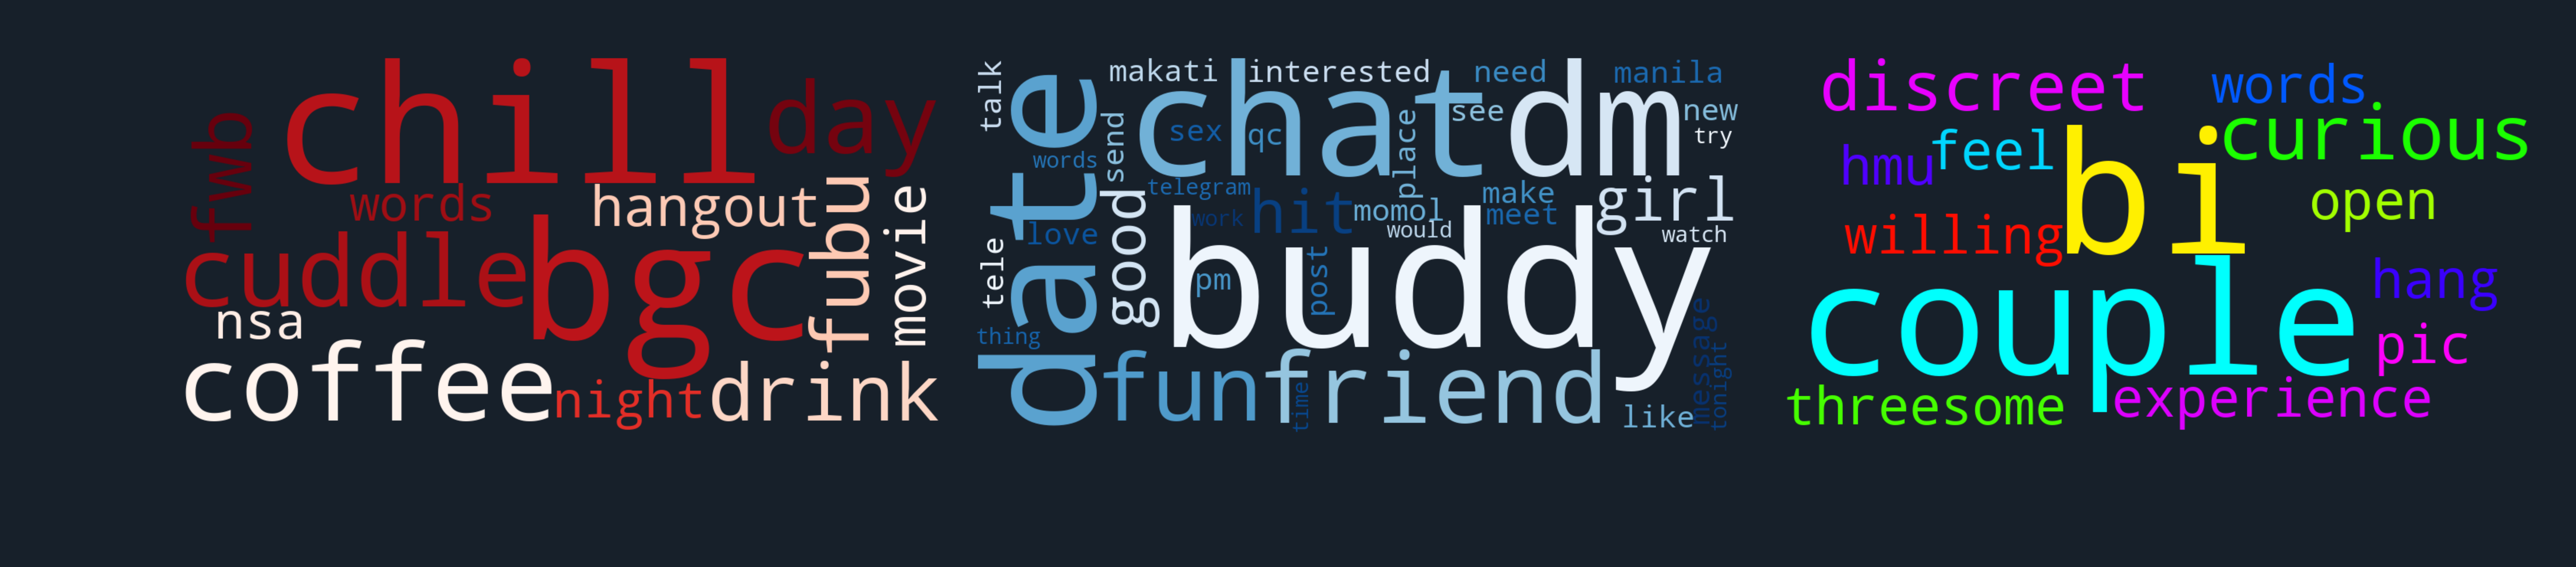

In [216]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, dpi=1500, facecolor='#17202a')
ax1.imshow(wordcloud1, interpolation='bilinear')
ax1.axis('off')
ax2.imshow(wordcloud2, interpolation='bilinear')
ax2.axis('off')
ax3.imshow(wordcloud3, interpolation='bilinear')
ax3.axis('off')
fig.tight_layout(pad=-2)
fig.savefig('wc.png')

Wordcloud above shows frequent items/words used by each and both orientations in this order:

* **LEFT: straight**
* **MIDDLE: both**
* **RIGHT: homosexuals**

We can see that the posts made by each sexual orientation greatly differ in content. We can infer that **homosexuals tend to be more explicit** on what they are looking for in phr4r, unlike **straight redditors who still hold back** despite the guaranteed anonimity in reddit.

### 2. Association rules per sexual orientation

In [1]:
import pandas as pd
import pickle

#### Load pickle file containing the association rules of words that are frequent to both orientations

In [2]:
with open('df_words_sub_ar.pkl', 'rb') as f:
    df = pickle.load(f)

#### Filter to rules with `confidence of at least 90%`

In [3]:
df_90 = df[df.confidence>=0.9]

#### Investigate words that may hold different rules per orientation

#### BUDDY:

In [4]:
df_90[df_90.word=='buddy']

antecedent consequent  confidence       lift  \
40             [read, open, like, chat]    [buddy]    0.934783  10.539955   
45                       [fitness, gym]    [buddy]    1.000000  11.623100   
50         [lot, people, friend, buddy]     [like]    1.000000  25.514199   
51    [people, love, like, send, buddy]   [friend]    1.000000  18.216566   
52           [bit, people, time, buddy]     [love]    1.000000  26.033292   
53        [open, people, friend, buddy]     [like]    1.000000  25.514199   
54  [people, love, send, friend, buddy]     [like]    1.000000  25.514199   

            so        from   word  
40    Straight  Consequent  buddy  
45  Homosexual  Consequent  buddy  
50    Straight  Antecedent  buddy  
51    Straight  Antecedent  buddy  
52    Straight  Antecedent  buddy  
53    Straight  Antecedent  buddy  
54    Straight  Antecedent  buddy

**Association with the word BUDDY:**

**Straight**
* love
* like
* friend
* chat
* read
* open
* game
* time

**Homosexual**
* fitness
* gym

#### LOVE:

In [5]:
df_90[df_90.word=='love']

antecedent    consequent  confidence  \
220                  [read, bit, old, post, time]        [love]         1.0   
221                [bit, game, old, friend, time]        [love]         1.0   
222  [mind, open, feel, like, friend, time, talk]        [love]         1.0   
223               [bit, game, post, friend, chat]        [love]         1.0   
224                     [mind, bit, open, people]        [love]         1.0   
230                 [mind, bit, free, love, like]        [time]         1.0   
231                 [com, read, love, like, send]        [open]         1.0   
232         [read, bit, people, post, love, time]        [feel]         1.0   
233              [open, feel, post, love, friend]        [time]         1.0   
234                       [bit, free, love, send]        [time]         1.0   
235                                  [term, love]        [long]         1.0   
236                         [height, great, love]  [interested]         1.0   
237                                  [fair, love]        [skin]         1.0   
238                                   [bod, love]         [dad]         1.0   
239                            [love, work, chat]        [talk]         1.0   

           lift          so        from  word  
220   26.033292    Straight  Consequent  love  
221   26.033292    Straight  Consequent  love  
222   26.033292    Straight  Consequent  love  
223   26.033292    Straight  Consequent  love  
224   26.033292    Straight  Consequent  love  
230   16.743061    Straight  Antecedent  love  
231   43.000000    Straight  Antecedent  love  
232   34.554828    Straight  Antecedent  love  
233   16.743061    Straight  Antecedent  love  
234   16.743061    Straight  Antecedent  love  
235   44.465116  Homosexual  Antecedent  love  
236   14.215613  Homosexual  Antecedent  love  
237   95.600000  Homosexual  Antecedent  love  
238  127.466667  Homosexual  Antecedent  love  
239    9.984334  Homosexual  Antecedent  love

**Association with the word LOVE:**

**Straight**
* game
* chat
* feel
* read
* old
* time
* friend
* like

**Homosexual**
* long
* term
* height
* dad
* bod
* interested
* fair
* skin

Given the results of the association rule mining on the words **buddy** and **love**, there is a **distinct difference** between the words associated to these against **homosexual and straight** redditors.

Particularly, **straight** users tend to associate ‘buddy’ and ‘love’ with closely similar words such as: **friend, chat, read, and time**. 

On the other hand, **homosexual** users associate the word ‘buddy’ with **fitness and gym** whereas the words about **physical appearance** are distinctly associated with the word ‘love’. 

Interestingly, this suggests that **homosexual users tend to be more straightforward and upfront** with stating their preferences and persona features when it comes to conversing about ‘love’ and **straight users would discuss the topic more casually**, incorporating the topics such as friendship, time, and reading.

#### PLACE:

In [6]:
df_90[df_90.word=='place']

antecedent consequent  confidence        lift          so  \
265             [provide, big]    [place]    1.000000   22.104046  Homosexual   
266  [provide, viber, willing]    [place]    1.000000   22.104046  Homosexual   
267           [provide, sweet]    [place]    1.000000   22.104046  Homosexual   
268        [marikina, willing]    [place]    1.000000   22.104046  Homosexual   
269              [provide, tg]    [place]    1.000000   22.104046  Homosexual   
270             [imgur, place]      [com]    1.000000  268.955414    Straight   
271        [feel, place, chat]     [time]    0.921569   15.429880    Straight   
272         [lot, open, place]     [post]    0.918367   27.659757    Straight   
273  [place, post, love, like]     [time]    0.916667   15.347806    Straight   
274        [mind, place, chat]     [time]    0.916667   15.347806    Straight   
275             [light, place]     [bdsm]    1.000000  191.200000  Homosexual   
276              [bdsm, place]    [light]    1.000000  159.333333  Homosexual   
277             [obese, place]    [viber]    1.000000   59.750000  Homosexual   
278   [big, experience, place]  [willing]    1.000000   25.664430  Homosexual   
279              [deed, place]  [willing]    1.000000   25.664430  Homosexual   

           from   word  
265  Consequent  place  
266  Consequent  place  
267  Consequent  place  
268  Consequent  place  
269  Consequent  place  
270  Antecedent  place  
271  Antecedent  place  
272  Antecedent  place  
273  Antecedent  place  
274  Antecedent  place  
275  Antecedent  place  
276  Antecedent  place  
277  Antecedent  place  
278  Antecedent  place  
279  Antecedent  place

**Association with the word PLACE:**

**Straight**
* feel
* chat
* open
* lot
* love
* time
* post

**Homosexual**
* marikina
* willing
* provide
* big
* sweet
* tg
* bdsm
* obese

It is notable that based on the results, **Marikina** is often associated by **homosexuals** to the word **place**. This may be attributed to the fact that the **Metro Manila Pride March**, an annual gathering of the LGBTQI+ community is **held and hosted by the Marikina City Government**. 

#### SEX:

In [11]:
df_90[df_90.word=='sex']

antecedent consequent  confidence       lift  \
205                 [decent, safe]      [sex]         1.0  29.190840   
206       [safe, body, clean, see]      [sex]         1.0  29.190840   
207          [safe, type, curious]      [sex]         1.0  29.190840   
208  [decent, safe, average, good]      [sex]         1.0  29.190840   
209              [safe, body, see]      [sex]         1.0  29.190840   
215        [safe, body, sex, good]     [type]         1.0  46.072289   
216            [safe, coffee, sex]     [type]         1.0  46.072289   
217     [safe, type, sex, curious]     [body]         1.0  40.680851   
218              [clean, pic, sex]     [body]         1.0  40.680851   
219   [decent, safe, average, sex]     [good]         1.0  16.412017   

             so        from word  
205  Homosexual  Consequent  sex  
206  Homosexual  Consequent  sex  
207  Homosexual  Consequent  sex  
208  Homosexual  Consequent  sex  
209  Homosexual  Consequent  sex  
215  Homosexual  Antecedent  sex  
216  Homosexual  Antecedent  sex  
217  Homosexual  Antecedent  sex  
218  Homosexual  Antecedent  sex  
219  Homosexual  Antecedent  sex

**Association with the word SEX:**

**Homosexual**
* decent
* safe
* body
* clean
* type
* curious
* drink

Given the results above, it is keen to note that **homosexuals** often associate the word **sex** with words such as: **safe, clean, curious**, etc. This results show that homosexual redditors are **keen on associating sexual activities with safety and cleanliness** – an idea often contradictory to the preconceived prejudice towards the LGBTQI+ community.

#### GIRL:

In [10]:
df_90[df_90.word=='girl']

antecedent    consequent  confidence       lift  \
125  [boyfriend, threesome, interested]        [girl]         1.0  11.247059   
126      [boyfriend, clean, interested]        [girl]         1.0  11.247059   
127         [boyfriend, dm, interested]        [girl]         1.0  11.247059   
128                      [eat, explore]        [girl]         1.0  11.247059   
129                     [boyfriend, dm]        [girl]         1.0  11.247059   
135            [boyfriend, clean, girl]  [interested]         1.0  14.215613   
136                  [hope, send, girl]        [talk]         1.0   9.984334   
137           [could, interested, girl]        [make]         1.0  21.604520   
138               [boyfriend, dm, girl]  [interested]         1.0  14.215613   
139                     [old, pm, girl]        [year]         1.0  33.840708   

             so        from  word  
125  Homosexual  Consequent  girl  
126  Homosexual  Consequent  girl  
127  Homosexual  Consequent  girl  
128  Homosexual  Consequent  girl  
129  Homosexual  Consequent  girl  
135  Homosexual  Antecedent  girl  
136  Homosexual  Antecedent  girl  
137  Homosexual  Antecedent  girl  
138  Homosexual  Antecedent  girl  
139  Homosexual  Antecedent  girl

**Association with the word GIRL:**

**Homosexual**
* boyfriend
* threesome
* interested
* clean
* explore
* eat

Users tagged as LGBTQI+ may not necessarily identify as such, since the frequent occurrence of the words **curious** and **explore** in their posts suggests that the platform is used to **explore bisexual curiosities**. This is consistent with our assumption that **anonymity brings out sentiments that otherwise would not surface** in other more visible platforms.

#### WATCH:

In [12]:
df_90[df_90.word=='watch']

antecedent   consequent  confidence       lift          so  \
285         [ft, height]      [watch]         1.0  25.157895  Homosexual   
295      [finger, watch]  [threesome]         1.0  20.232804  Homosexual   
296  [watch, work, talk]      [movie]         0.9  34.763636  Homosexual   

           from   word  
285  Consequent  watch  
295  Antecedent  watch  
296  Antecedent  watch

**Association with the word WATCH:**

**Homosexual**
* height
* finger
* threesome
* work
* talk
* movie

Note that the words **sex, girl and watch** only have association rules with confidence of at least 90% on posts by **homosexual** redditors.

### 3. Association rules with words that pertain to certain cities

#### QC:

In [7]:
df_90[df_90.word=='qc']

antecedent consequent  confidence    lift          so        from word
15  [provide, qc]    [viber]         1.0  59.750  Homosexual  Antecedent   qc
16    [sweet, qc]    [viber]         0.9  53.775  Homosexual  Antecedent   qc

**Association with the word QC:**

**Homosexual**
* provide
* sweet
* viber

#### MANILA:

In [8]:
df_90[df_90.word=='manila']

antecedent consequent  confidence       lift          so  \
25         [metro, telegram]   [manila]    0.909091  10.194615  Homosexual   
35  [chat, telegram, manila]     [talk]    1.000000   9.984334  Homosexual   

          from    word  
25  Consequent  manila  
35  Antecedent  manila

**Association with the word MANILA:**

**Homosexual**
* telegram
* chat
* talk

#### MAKATI:

In [9]:
df_90[df_90.word=='makati']

antecedent consequent  confidence       lift        so        from  \
80   [dominant, taft]   [makati]    0.977778  13.195156  Straight  Consequent   
81  [dominant, pasay]   [makati]    0.956522  12.908305  Straight  Consequent   

      word  
80  makati  
81  makati

**Association with the word MAKATI:**

**Homosexual**
* dominant
* taft
* pasay


Interestingly, the words displayed above (**qc, manila and makati**) only have association rules with confidence of at least 90% on posts by **homosexual** redditors.

## V. Conclusion

Based on our findings, we saw that Filipino Redditors more often speak of similar things but in different contexts. For example, when heterosexuals talk about “buddy” they mean a friend they can chat or spend time with. On the other hand, those from the LGBT community often refer to a “buddy” as someone who they go to the gym with or someone who engages in the same fitness routine. 

Another insight that we got from our study is that Redditors may explicitly be looking for similar things but implicitly mean different things. For example, when heterosexuals say “fun” some might just be looking for people who are interesting and they could spend time with. For the LGBT, “fun” meant having good, clean sex.  

Moreover, in the Philippine R4R, depending on the area, Redditors differ in what they search for. For example, LGBT in Manila just seek people to chat and talk with, while in Quezon City, they look for those who are sweet and provide. On the other hand, in Makati heterosexuals look for dominant companions. 

Overall, we see that the phr4r community is vibrant and diverse, with a language that is different from the usual context of normal conversation. 

Some possible applications for our study include the (1) identification of possible deviant behavior, such as those who seek minors for companionship (pedophiles), which could aid the authorities in investigating them; (2) the tracking of sexual health through monitoring of online activities. This can be useful for the Department of Health especially on how highly communicable sexually transmitted diseases such as AIDS spread in certain geographic areas; (3) gain marketing insight for use in different products such as cellular phones, coffee shops, etc.; (4) creation of a mobile app for date matching whose primary feature is anonymity. 

## VI. Acknowledgement
Special thanks to Professor Christian Alis, Professor Madhavi Devaraj, and Professor Eduardo David of the Asian Institute of Management (Manila, Philippines) for their guidance and support.

## VII. References

https://www.redditinc.com/ 

https://www.reddit.com/r/r4r/comments/6nwgck/meta_welcome_to_rr4r_please_read_this_before/ 

Curlew, A. E. (2019). Undisciplined Performativity: A Sociological Approach to Anonymity. Social Media+ Society, 5(1), 2056305119829843. 

Fournier-Viger, P., Lin, J. C. W., Vo, B., Chi, T. T., Zhang, J., & Le, H. B. A survey of itemset mining. WIREs Data Min. Knowl. Discov. e1207 (2017). 

Aggarwal, C. C. (2016). Recommender systems (pp. 1-28). Cham: Springer International Publishing. 

Arora, J., Bhalla, N., Rao, S. (2013). A Review on Association Rule Mining Algorithms, IJIRCCE International Journal of Innovative Research in Computer and Communication Engineering, Vol. 1, Issue 5, July 2013. 

Black, S. W., Kaminsky, G., Hudson, A., Owen, J., & Fincham, F. (2019). A Short-Term Longitudinal Investigation of Hookups and Holistic Outcomes Among College Students. Archives of sexual behavior, 1-17. 

Barcz, M., Gryz, J., & Wierzbicki, A. (2019). The Logical Structure of Intentional Anonymity. Diametros, (60), 1-17. 